<a href="https://colab.research.google.com/github/zhaoyu-zhang/PDGM-Geometric_Asian/blob/master/geometric_asian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Functional Feynman-Kac Formula [Dupire (2009)]

Let $x$ be a process given by the SDE 
$$dx_s = \mu(X_s) ds + \sigma(X_s) dw_x.$$

Consider functionals $g :\Lambda_T \longrightarrow R$, $\lambda: \Lambda \longrightarrow R$ and $k:\Lambda \longrightarrow R$ and define the functional $f$ as
$$f(Y_t) = E\left[\left.e^{-\int_t^T \lambda(X_u) du} g(X_T) + \int_t^T e^{-\int_t^s \lambda(X_u) du} k(X_s) ds \ \right| \ Y_t \right],$$
for any path $Y_t \in \Lambda$, $t \in [0,T]$ Thus, if $f \in C^{1,2}$ and $k$, $\lambda$, $\mu$ and $\sigma$ are $\Lambda$-continuous, then $f$ satisfies the Path-dependent Partial Differential Equation (PPDE):
\begin{align}\label{eq:feynman-kac-equation}
\Delta_t f(Y_t) + \mu(Y_t) \Delta_x f(Y_t)  + \frac{1}{2} \sigma^2(Y_t) \Delta_{xx} f(Y_t) - \lambda(Y_t)f(Y_t) + k(Y_t) = 0,
\end{align}
with $f(Y_T) = g(Y_T)$, for any $Y_t$ in the topological support of $x$.



# Geometric Asian Option

Under Black--Scholes setting, where the spot value follows a Geometric Brownian Motion with constant parameters
$$dx_t = (r - q)x_tdt + \sigma x_t dw_t.$$

Under this model, the price of a geometric Asian optin with maturity $T$ and payoff $g: \Lambda_T \longrightarrow R$ solves the PPDE
\begin{align}\label{eqn:PPDE_BS}
\begin{cases}
\Delta_t f(Y_t) + (r - q) y_t \Delta_x f(Y_t) + \displaystyle \frac{1}{2}\sigma^2 y_t^2 \Delta_{xx} f(Y_t) - r f(Y_t) = 0,\\[10pt]
f(Y_T) = g(Y_T) = \left(\exp\left\{\frac{1}{T} \int_0^T \log y_t dt \right\} - K\right)^+.
\end{cases}
\end{align}

# Our Method

Approximate $f(X_t)$ using a combination of LSTM network and a feedforward NN, and use finite difference to find gradients. See detail in paper.

In [1]:
"""
    Python 3.5
    Keras 2.2.2
    Tensorflow 1.10.0
"""
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import tensorflow as tf
import time as ttt

import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM
from keras.optimizers import Adam
from keras.regularizers import L1L2



Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  
config.log_device_placement = True                           
sess = tf.InteractiveSession(config=config)
set_session(sess)  # set TensorFlow session as the default session for Keras

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [0]:
M = 128 # number of samples in a batch
T = 1 # terminal time
dt = 0.01 # detla_t = 0.01, 0.005, 0.002, 0.001
steps = int(T/dt) # number of time steps
r = 0.03
q = 0.01 
sigma = 1
x_0 = 1.0 # X_0 
Strike = 0.4 #Strike Price

In [0]:
def generate_t(T, steps, M = M):
    '''
    time discretization (M * (steps+1 +1)) 
    for computing the time derivative, we need an extra time step.
    '''
    t_temp = np.linspace(1e-6, T- 1e-6, steps +1, dtype = np.float32)
    return np.tile(np.concatenate((t_temp, [T + dt])), (M,1)) # extra after terminal

In [5]:
# for example
t = generate_t(T, steps)[0][0:-1]
print("the length of t is {}".format(len(t)+1))

the length of t is 102


In [0]:
def Create_paths(i, M):
    '''
    GBM paths (M * (steps+1)) with seed i
    number of steps could be 100, 200, 500, 1000.
    '''
    
    # generate time steps for each path
    np.random.seed(i)
    x = np.tile(x_0, (M, 1))
    path = np.tile(x_0, (M, 1))
    delta = T/1000
    
    dW = np.sqrt(delta)*np.random.normal(size=(M, 1000))
    for k in range(1000):
        x += (r-q) * x * delta + sigma * x * dW[:,k:k+1]
        path = np.concatenate((path, x), axis = 1)
        
    #  select # of steps (100, 200, 500, 1000) from total 1000 timesteps
    selection = np.linspace(0,1000, steps+1, dtype = np.int) 
    path = np.array(path, dtype=np.float32)
    path_selection = path[:,selection]

    return np.array(path_selection, dtype=np.float32)

Text(0.5, 0, 'Time')

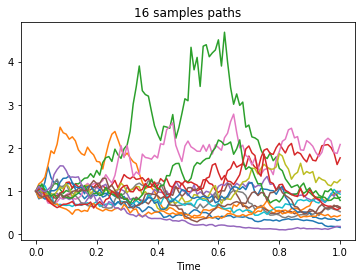

In [7]:
for i in range(16):
    plt.plot(t, Create_paths(100000000, M)[i])
plt.title("16 samples paths")
plt.xlabel("Time")

In [0]:
# input time and path as placeholders
path = tf.placeholder(dtype=tf.float32, shape=[M,steps+1])
time = tf.placeholder(dtype = tf.float32, shape = [M, steps +1 + 1]) # extra after T

## True Solution and Terminal Condition

 A closed-form solution is available in this case:
$$f(Y_t) = e^{-r(T-t)} \left(G_t^{t/T}y_t^{1 - t/T} e^{\bar{\mu} + \bar{\sigma}^2/2} \Phi(d_1) - K\Phi(d_2) \right),$$
where $\Phi$ is the cumulative distribution function of the standard normal,
\begin{align}
G_t &= \exp\left\{\frac{1}{t} \int_0^t \log y_u du \right\}\\
\bar{\mu} &= \left(r - q - \frac{\sigma^2}{2}\right)\frac{1}{2T}(T-t)^2,\\
\bar{\sigma} &= \frac{\sigma}{T} \sqrt{\frac{1}{3}(T-t)^3},\\
d_2 &= \frac{(t/T) \log G_t + \left(1 - t/T\right) \log y_t + \bar{\mu} - \log K}{\bar{\sigma}},\\
d_1 &= d_2 + \bar{\sigma}.
\end{align}
In the numerical examples below, we fix the strike price to $K = 0.4$. 

In [0]:
def true_solution(apath):
    '''
    Givin a path, it outputs the true solution.
    '''
    G = 1
    mu_bar = (r-q-sigma**2/2)/2/T * (T-t[0])**2
    sigma_bar = sigma/T * np.sqrt(1/3*(T-t[0])**3)
    d_2 = 1/sigma_bar * (t[0]/T * np.log(G) + (1 - t[0]/T) * np.log(apath[0]) + mu_bar - np.log(Strike))
    d_1 = d_2 + sigma_bar
    true_solution = [np.exp(-r*(T - t[0])) * ( G**(t[0]/T) * (apath[0] **(1-t[0]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                    - Strike * norm.cdf(d_2))]
    
    for k in range(1, steps+1):
        G = np.exp(1/t[k] * np.sum((np.log(apath[1:k+1]) + np.log(apath[:k]) )/2)*dt)
        mu_bar = (r-q-sigma**2/2)/2/T * (T-t[k])**2
        sigma_bar = sigma/T * np.sqrt(1/3*(T-t[k])**3)
        d_2 = 1/sigma_bar * (t[k]/T * np.log(G) + (1 - t[k]/T) * np.log(apath[k]) + mu_bar - np.log(Strike))
        d_1 = d_2 + sigma_bar
        true_solution.append(np.exp(-r*(T - t[k])) * (G**(t[k]/T) * (apath[k] **(1-t[k]/T)) * np.exp(mu_bar + sigma_bar**2/2) * norm.cdf(d_1) 
                        - Strike * norm.cdf(d_2)))

    return true_solution

In [0]:
def terminal_condition(apath):
    '''
    Givin a path, it outputs the terminal condition g(Y_T).
    '''
    
    return np.maximum(np.exp(1/T*sum( (np.log(apath[1:]) + np.log(apath[:-1]) )/2)*dt) - Strike,0)

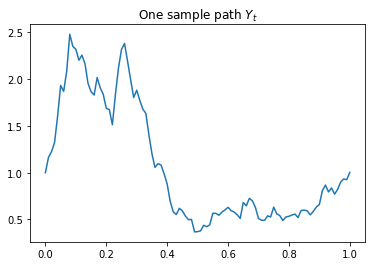

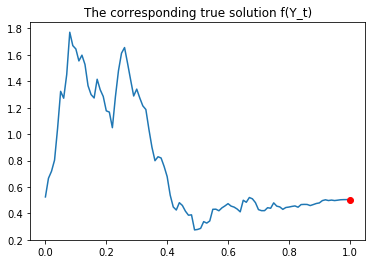

In [11]:
# for example given a GBM path
path1 = Create_paths(100000000, M)[1]
plt.plot(t, path1)
plt.title("One sample path $Y_t$")
plt.show()

plt.plot(t, true_solution(path1))
plt.plot(T, terminal_condition(path1), "ro")
plt.title("The corresponding true solution f(Y_t)")
plt.show()

## Neural Network Setup

The path-dependent function $f(X_t)$ is been approximated by a combination of LSTM and a feedforward neural network.

In [12]:
n_a = 128 # number of hidden neurons in the LSTM network
LSTM_cell = LSTM(n_a, return_state = True) # This is used to capture the long term dependency

# This feedforward neural network is used to compute the derivatives.
# input dimension is (1+1+n_a) = (space, time, path (which is characterized by n_a hidden neurons))
NN = Sequential([
    Dense(128, input_shape=(1+1+n_a,)),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(128),
    Activation('tanh'),
    Dense(1)
])

## Objective Function

\begin{align}\label{eq:loss_NM}
J_{N,M}(\theta) = \frac{1}{M} \frac{1}{N}\sum_{j=1}^M \sum_{i=0}^N \left(\Delta_{t} u(Y^{(j)}_{t_i};\theta) + L u(Y^{(j)}_{t_i};\theta)\right)^2 +  \frac{1}{M}\sum_{j=1}^M \left(u(Y^{(j)}_{t_N}; \theta) - g(Y_{t_N}^{(j)}) \right)^2.
\end{align}

In [0]:
def loss_function(time,path, M):
    
    a = tf.Variable(tf.zeros([M, n_a]), trainable=False)
    c = tf.Variable(tf.zeros([M, n_a]), trainable=False)

##. Approximate f(X_{t_0})
    input_x = K.slice(path, [0,0], [M,1])
    input_t = K.slice(time, [0,0], [M,1])
    inputt_f = K.concatenate([input_x, input_t, a])
    f = NN(inputt_f)
                      
##.   calculate space derivatives
    bump = 0.01 * input_x
    input_x_up = input_x + bump
    inputt_up = K.concatenate([input_x_up, input_t, a])
    f_up = NN(inputt_up)
    input_x_down = input_x - bump
    inputt_down = K.concatenate([input_x_down, input_t, a])
    f_down = NN(inputt_down)
    partial_x_f = (f_up - f)/bump
    partial_xx_f = (f_up - 2*f + f_down)/bump/bump

##. Next LSTM cell
    input_x_reshape = tf.reshape(input_x, (M,1,1))
    input_t_reshape = tf.reshape(input_t, (M,1,1))
    inputt = K.concatenate([input_x_reshape, input_t_reshape])
    a, _, c = LSTM_cell(inputt, initial_state = [a, c])
    
##.   calculate time derivative
    input_t_time = K.slice(time, [0, 1], [M, 1])
    inputt_time = K.concatenate([input_x, input_t_time, a])
    f_flat = NN(inputt_time)
    partial_t_f = (f_flat - f)/dt
    
    Loss = tf.reduce_sum(tf.square(partial_t_f + (r-q)*input_x * partial_x_f + 0.5 * sigma**2 * input_x **2 * partial_xx_f - r * f)) 

    solution = f
    time_derivative = partial_t_f 
    space_derivative = partial_x_f
    space_2nd_derivative = partial_xx_f

    #############################################################################
    for i in range(1, steps+1): # Iterate through every timestep
        
        ##. Approximate f(X_{t_i})
        input_x = K.slice(path, [0,i], [M,1])
        input_t = K.slice(time, [0,i], [M,1])
        inputt_f = K.concatenate([input_x, input_t, a])
        f = NN(inputt_f)
        
        ##. calculate space derivative
        bump = 0.01 * input_x
        input_x_up = input_x + bump
        inputt_up = K.concatenate([input_x_up, input_t, a])
        f_up = NN(inputt_up)
        input_x_down = input_x - bump
        inputt_down = K.concatenate([input_x_down, input_t, a])
        f_down = NN(inputt_down)
        partial_x_f = (f_up - f)/bump
        partial_xx_f = (f_up - 2*f + f_down)/bump/bump
    
        ##. Next LSTM cell
        input_x_reshape = tf.reshape(input_x, (M,1,1))
        input_t_reshape = tf.reshape(input_t, (M,1,1))
        inputt = K.concatenate([input_x_reshape, input_t_reshape])
        a, _, c = LSTM_cell(inputt, initial_state = [a, c])

        ##. calculate time derivative
        input_t_time = K.slice(time, [0, i+1], [M, 1])
        inputt_time = K.concatenate([input_x, input_t_time, a])
        f_flat = NN(inputt_time)
        partial_t_f = (f_flat - f)/dt
        
        Loss += tf.reduce_sum(tf.square(partial_t_f + (r-q) * input_x * partial_x_f + 0.5*sigma**2 * input_x **2 *partial_xx_f - r* f)) 

        solution = K.concatenate([solution, f]) 
        time_derivative = K.concatenate([time_derivative, partial_t_f]) 
        space_derivative = K.concatenate([space_derivative, partial_x_f])
        space_2nd_derivative = K.concatenate([space_2nd_derivative, partial_xx_f])

    #############################################################################
    ##. Terminal cost
    Loss += tf.reduce_sum( tf.square( f - tf.math.maximum(tf.exp(1/T*tf.reduce_sum((tf.log(path[:,1:]) + tf.log(path[:, :-1]))/2 * dt, axis= 1, keepdims=True))- Strike, 0)))*steps

    return Loss/M/steps, solution, time_derivative, space_derivative, space_2nd_derivative

## SGD

In [0]:
Epoch = 20000+1

In [0]:
loss, solution, time_derivative, space_derivative, space_2nd_derivative = loss_function(time, path, M)

In [16]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
# exponential decay learning rate
learning_rate = tf.maximum(tf.train.exponential_decay(starter_learning_rate, global_step, 50, 0.98, staircase=True), tf.constant(0.00001))
# adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=5.0)
train_op = optimizer.minimize(loss, global_step=global_step)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [0]:
np.random.seed(8)
# GBM
path_test = Create_paths(100000000, M)
time_feed = generate_t(T, steps, M)
pred_dict = {path: path_test, time: time_feed}

# Linear
path_test2 = np.tile(np.linspace(2, 1e-6, steps+1), (M,1))
pred_dict2 = {path: path_test2, time: time_feed}

train_loss_list = []
test_loss_list = []

1th Epoch:
traing loss is 84.67687225341797, test loss is 84.61848449707031, and learning rate is 0.009999999776482582, elapsed is 55.86963224411011.
 


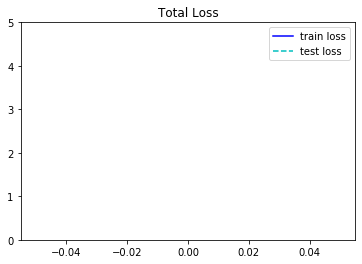

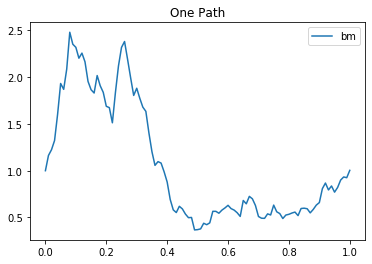

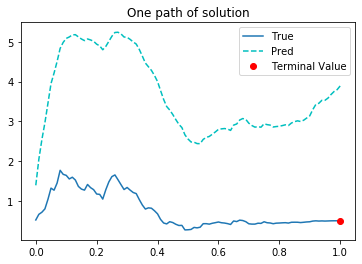

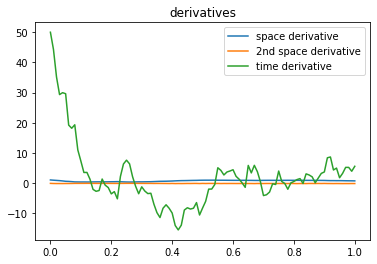

11th Epoch:
traing loss is 0.4736877679824829, test loss is 0.4486861526966095, and learning rate is 0.009999999776482582, elapsed is 9.145673990249634.
 
21th Epoch:
traing loss is 0.1838650107383728, test loss is 0.15302301943302155, and learning rate is 0.009999999776482582, elapsed is 4.350210189819336.
 
31th Epoch:
traing loss is 0.11752226203680038, test loss is 0.12522822618484497, and learning rate is 0.009999999776482582, elapsed is 4.3070433139801025.
 
41th Epoch:
traing loss is 0.08663997799158096, test loss is 0.09519574791193008, and learning rate is 0.009999999776482582, elapsed is 4.424328804016113.
 
51th Epoch:
traing loss is 0.10716123878955841, test loss is 0.09489233046770096, and learning rate is 0.009799999184906483, elapsed is 4.398758888244629.
 
61th Epoch:
traing loss is 0.10728471726179123, test loss is 0.0924329087138176, and learning rate is 0.009799999184906483, elapsed is 4.27359676361084.
 
71th Epoch:
traing loss is 0.07067486643791199, test loss is 0

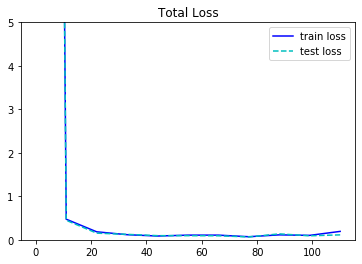

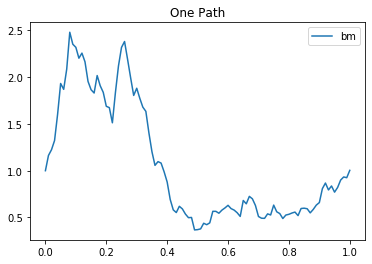

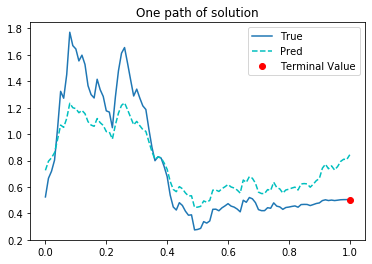

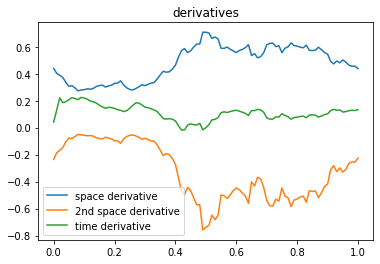

111th Epoch:
traing loss is 0.14703214168548584, test loss is 0.14670071005821228, and learning rate is 0.009603999555110931, elapsed is 4.981057405471802.
 
121th Epoch:
traing loss is 0.10163436830043793, test loss is 0.08802720904350281, and learning rate is 0.009603999555110931, elapsed is 4.308855772018433.
 
131th Epoch:
traing loss is 0.06339835375547409, test loss is 0.07447769492864609, and learning rate is 0.009603999555110931, elapsed is 4.353978157043457.
 
141th Epoch:
traing loss is 0.10119336098432541, test loss is 0.12499181926250458, and learning rate is 0.009603999555110931, elapsed is 4.2712790966033936.
 
151th Epoch:
traing loss is 0.0922205001115799, test loss is 0.06729122996330261, and learning rate is 0.009411919862031937, elapsed is 4.256914377212524.
 
161th Epoch:
traing loss is 0.08203798532485962, test loss is 0.07916259765625, and learning rate is 0.009411919862031937, elapsed is 4.245651483535767.
 
171th Epoch:
traing loss is 0.07515068352222443, test l

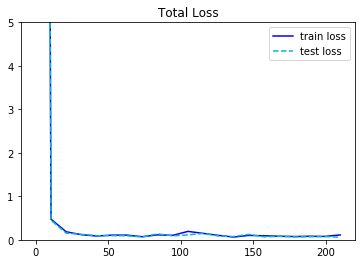

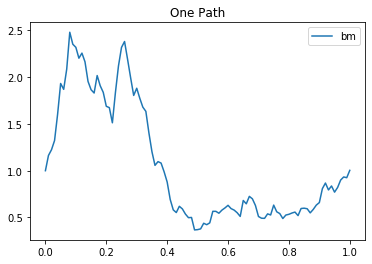

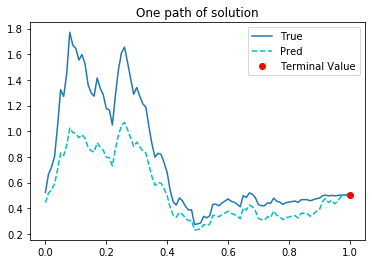

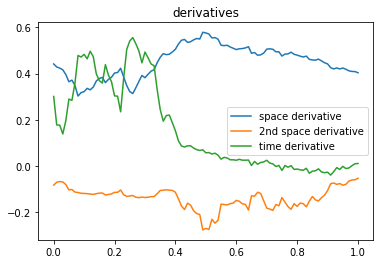

211th Epoch:
traing loss is 0.05842394009232521, test loss is 0.04870924353599548, and learning rate is 0.00922368187457323, elapsed is 4.988906383514404.
 
221th Epoch:
traing loss is 0.05251782014966011, test loss is 0.0539591945707798, and learning rate is 0.00922368187457323, elapsed is 4.287039041519165.
 
231th Epoch:
traing loss is 0.05528431758284569, test loss is 0.06042158231139183, and learning rate is 0.00922368187457323, elapsed is 4.286867380142212.
 
241th Epoch:
traing loss is 0.05428795889019966, test loss is 0.06167533993721008, and learning rate is 0.00922368187457323, elapsed is 4.2703328132629395.
 
251th Epoch:
traing loss is 0.05224790424108505, test loss is 0.03980227932333946, and learning rate is 0.00903920829296112, elapsed is 4.311725616455078.
 
261th Epoch:
traing loss is 0.05393737182021141, test loss is 0.033519197255373, and learning rate is 0.00903920829296112, elapsed is 4.265936851501465.
 
271th Epoch:
traing loss is 0.04038579761981964, test loss i

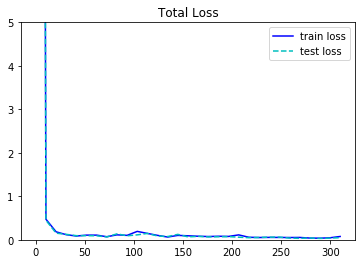

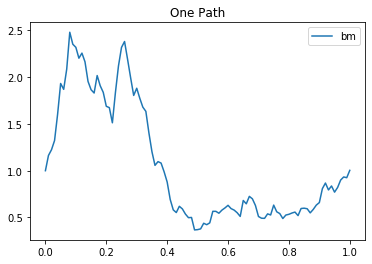

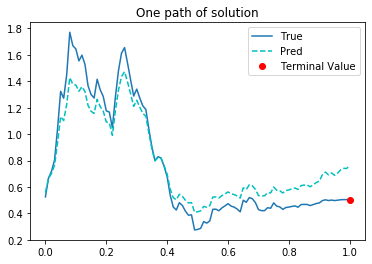

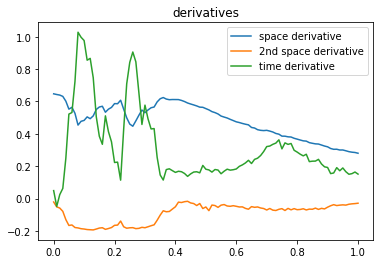

311th Epoch:
traing loss is 0.029855811968445778, test loss is 0.02359396405518055, and learning rate is 0.008858424611389637, elapsed is 5.041874408721924.
 
321th Epoch:
traing loss is 0.025638408958911896, test loss is 0.01728096790611744, and learning rate is 0.008858424611389637, elapsed is 4.292735576629639.
 
331th Epoch:
traing loss is 0.017703978344798088, test loss is 0.01750779338181019, and learning rate is 0.008858424611389637, elapsed is 4.269449710845947.
 
341th Epoch:
traing loss is 0.021561989560723305, test loss is 0.019870232790708542, and learning rate is 0.008858424611389637, elapsed is 4.2796056270599365.
 
351th Epoch:
traing loss is 0.03964636102318764, test loss is 0.03592431917786598, and learning rate is 0.00868125632405281, elapsed is 4.3011932373046875.
 
361th Epoch:
traing loss is 0.023729436099529266, test loss is 0.01575966365635395, and learning rate is 0.00868125632405281, elapsed is 4.3390161991119385.
 
371th Epoch:
traing loss is 0.012638032436370

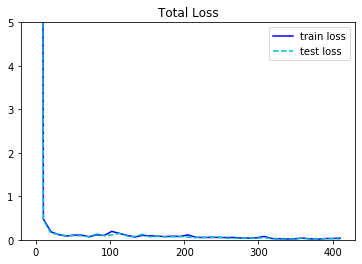

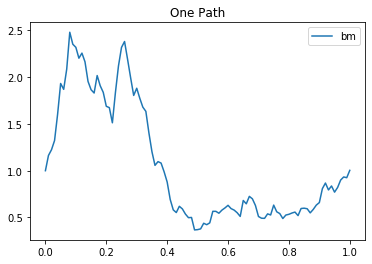

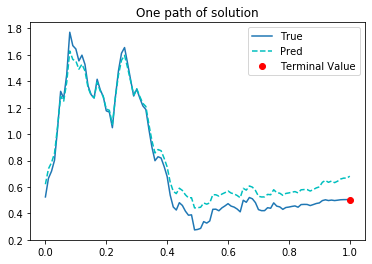

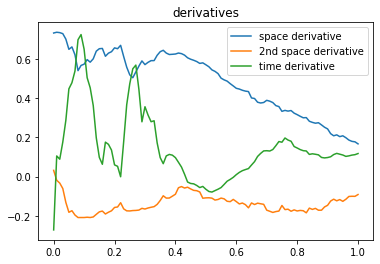

411th Epoch:
traing loss is 0.012911949306726456, test loss is 0.009554069489240646, and learning rate is 0.008507630787789822, elapsed is 4.948298454284668.
 
421th Epoch:
traing loss is 0.01070350781083107, test loss is 0.008022160269320011, and learning rate is 0.008507630787789822, elapsed is 4.296175241470337.
 
431th Epoch:
traing loss is 0.009974376298487186, test loss is 0.009929530322551727, and learning rate is 0.008507630787789822, elapsed is 4.300027132034302.
 
441th Epoch:
traing loss is 0.06470002979040146, test loss is 0.05618230998516083, and learning rate is 0.008507630787789822, elapsed is 4.275964260101318.
 
451th Epoch:
traing loss is 0.03300923481583595, test loss is 0.0305514857172966, and learning rate is 0.008337478153407574, elapsed is 4.311777830123901.
 
461th Epoch:
traing loss is 0.032962583005428314, test loss is 0.026560340076684952, and learning rate is 0.008337478153407574, elapsed is 4.303461313247681.
 
471th Epoch:
traing loss is 0.0126512022688984

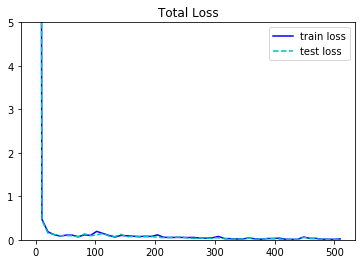

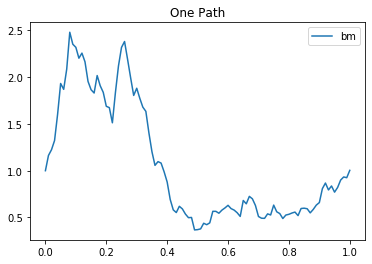

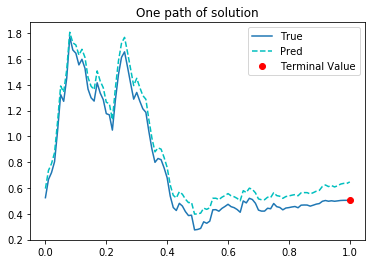

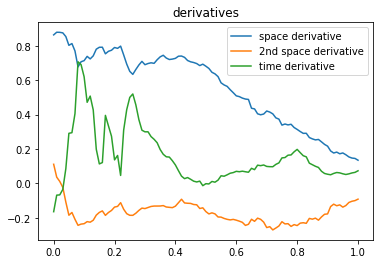

511th Epoch:
traing loss is 0.007235073950141668, test loss is 0.005759513936936855, and learning rate is 0.008170729503035545, elapsed is 5.008950710296631.
 
521th Epoch:
traing loss is 0.009326709434390068, test loss is 0.009535248391330242, and learning rate is 0.008170729503035545, elapsed is 4.285665988922119.
 
531th Epoch:
traing loss is 0.004644003696739674, test loss is 0.004324820823967457, and learning rate is 0.008170729503035545, elapsed is 4.3536341190338135.
 
541th Epoch:
traing loss is 0.011049635708332062, test loss is 0.011356519535183907, and learning rate is 0.008170729503035545, elapsed is 4.2917609214782715.
 
551th Epoch:
traing loss is 0.007901741191744804, test loss is 0.005779255647212267, and learning rate is 0.00800731498748064, elapsed is 4.290578365325928.
 
561th Epoch:
traing loss is 0.015294556505978107, test loss is 0.010179203003644943, and learning rate is 0.00800731498748064, elapsed is 4.347005128860474.
 
571th Epoch:
traing loss is 0.0186661742

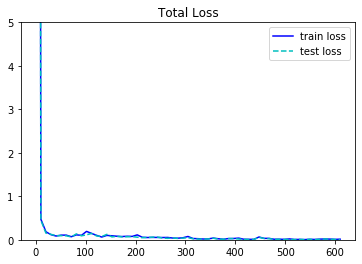

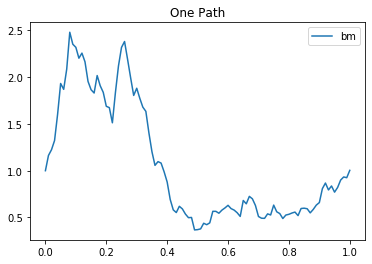

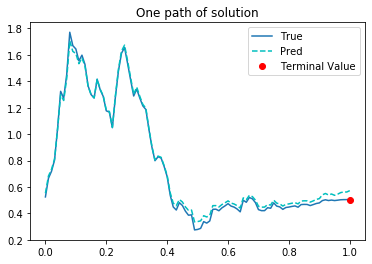

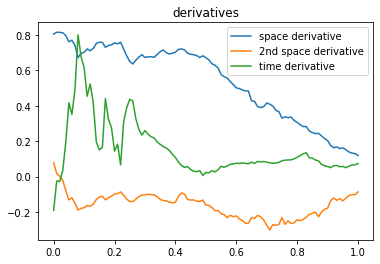

611th Epoch:
traing loss is 0.006457617972046137, test loss is 0.003861930686980486, and learning rate is 0.007847168482840061, elapsed is 4.992404222488403.
 
621th Epoch:
traing loss is 0.0058184280060231686, test loss is 0.005635765381157398, and learning rate is 0.007847168482840061, elapsed is 4.473016738891602.
 
631th Epoch:
traing loss is 0.006249468307942152, test loss is 0.00719428900629282, and learning rate is 0.007847168482840061, elapsed is 4.419559001922607.
 
641th Epoch:
traing loss is 0.01596941612660885, test loss is 0.016080431640148163, and learning rate is 0.007847168482840061, elapsed is 4.418097972869873.
 
651th Epoch:
traing loss is 0.008047911338508129, test loss is 0.007192160002887249, and learning rate is 0.007690225727856159, elapsed is 4.375176906585693.
 
661th Epoch:
traing loss is 0.011019444093108177, test loss is 0.006896342150866985, and learning rate is 0.007690225727856159, elapsed is 4.3830485343933105.
 
671th Epoch:
traing loss is 0.0101594505

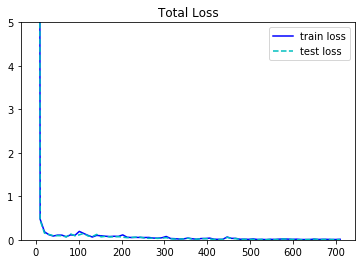

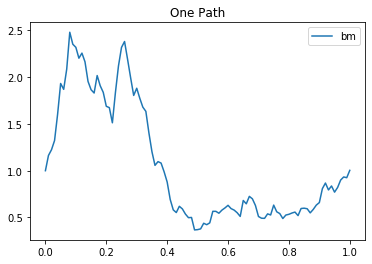

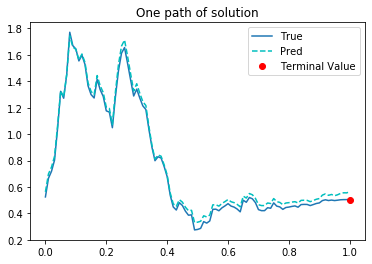

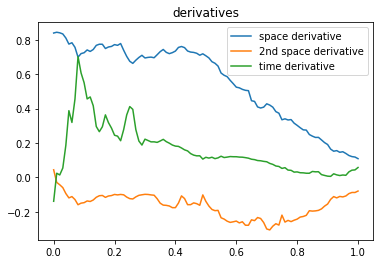

711th Epoch:
traing loss is 0.007524230517446995, test loss is 0.005958098918199539, and learning rate is 0.007536421064287424, elapsed is 5.064580678939819.
 
721th Epoch:
traing loss is 0.005104705225676298, test loss is 0.005137389525771141, and learning rate is 0.007536421064287424, elapsed is 4.39883279800415.
 
731th Epoch:
traing loss is 0.0035719661973416805, test loss is 0.004171852488070726, and learning rate is 0.007536421064287424, elapsed is 4.371145486831665.
 
741th Epoch:
traing loss is 0.003937527537345886, test loss is 0.0029711329843848944, and learning rate is 0.007536421064287424, elapsed is 4.278681755065918.
 
751th Epoch:
traing loss is 0.0029288011137396097, test loss is 0.0027793836779892445, and learning rate is 0.007385693024843931, elapsed is 4.350358486175537.
 
761th Epoch:
traing loss is 0.008256047032773495, test loss is 0.004151748958975077, and learning rate is 0.007385693024843931, elapsed is 4.285560131072998.
 
771th Epoch:
traing loss is 0.0058673

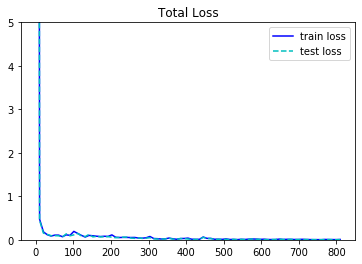

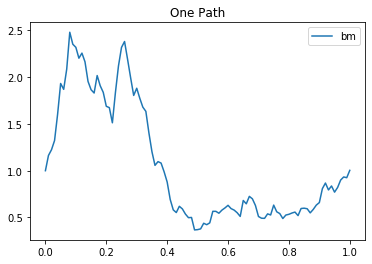

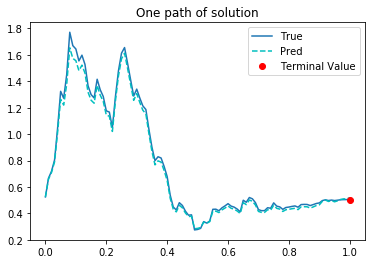

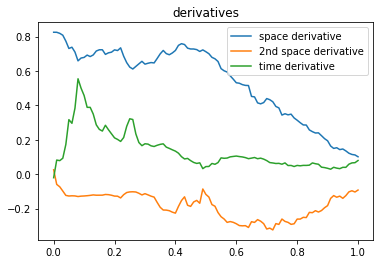

811th Epoch:
traing loss is 0.009182182140648365, test loss is 0.00564863346517086, and learning rate is 0.007237979210913181, elapsed is 5.013502359390259.
 
821th Epoch:
traing loss is 0.0061178505420684814, test loss is 0.0065381634049117565, and learning rate is 0.007237979210913181, elapsed is 4.400834560394287.
 
831th Epoch:
traing loss is 0.0039964597672224045, test loss is 0.00438637426123023, and learning rate is 0.007237979210913181, elapsed is 4.332760810852051.
 
841th Epoch:
traing loss is 0.004193022381514311, test loss is 0.004269010853022337, and learning rate is 0.007237979210913181, elapsed is 4.300939559936523.
 
851th Epoch:
traing loss is 0.0033455181401222944, test loss is 0.0031981777865439653, and learning rate is 0.007093219552189112, elapsed is 4.296927452087402.
 
861th Epoch:
traing loss is 0.009623806923627853, test loss is 0.003742643864825368, and learning rate is 0.007093219552189112, elapsed is 4.380714654922485.
 
871th Epoch:
traing loss is 0.0090044

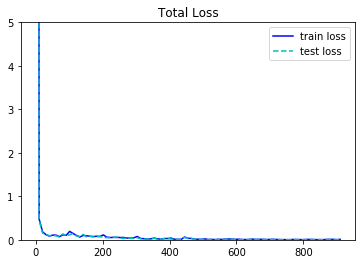

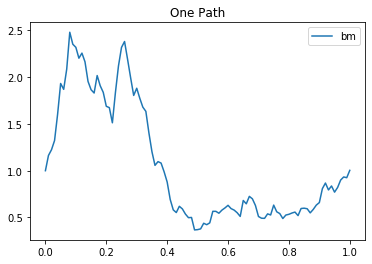

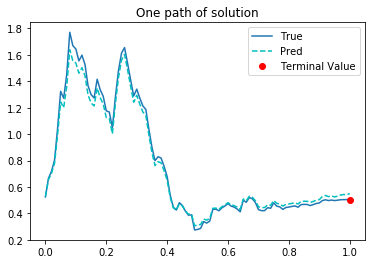

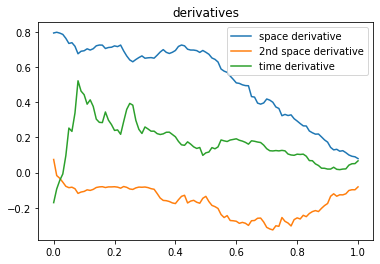

911th Epoch:
traing loss is 0.004611443728208542, test loss is 0.0033726226538419724, and learning rate is 0.006951355375349522, elapsed is 4.9943859577178955.
 
921th Epoch:
traing loss is 0.007139136083424091, test loss is 0.0071297260001301765, and learning rate is 0.006951355375349522, elapsed is 4.323280334472656.
 
931th Epoch:
traing loss is 0.0022311662323772907, test loss is 0.0024398716632276773, and learning rate is 0.006951355375349522, elapsed is 4.3253631591796875.
 
941th Epoch:
traing loss is 0.009608539752662182, test loss is 0.00938169751316309, and learning rate is 0.006951355375349522, elapsed is 4.329057931900024.
 
951th Epoch:
traing loss is 0.004893973469734192, test loss is 0.004692377522587776, and learning rate is 0.006812328472733498, elapsed is 4.300007343292236.
 
961th Epoch:
traing loss is 0.010098827071487904, test loss is 0.006572600454092026, and learning rate is 0.006812328472733498, elapsed is 4.311819076538086.
 
971th Epoch:
traing loss is 0.00583

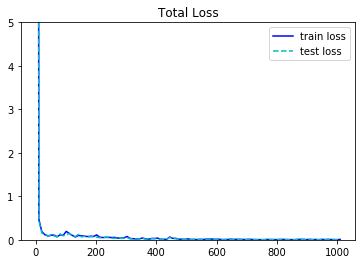

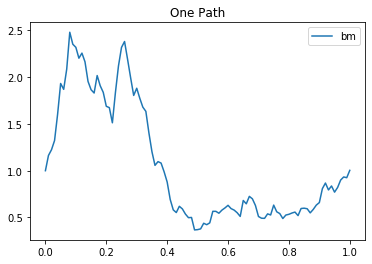

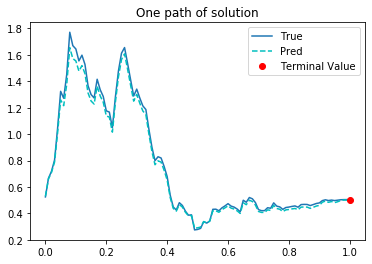

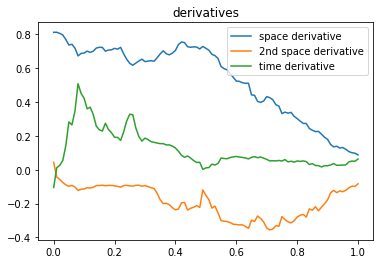

1011th Epoch:
traing loss is 0.0034333127550780773, test loss is 0.0025397855788469315, and learning rate is 0.006676082499325275, elapsed is 5.069462299346924.
 
1021th Epoch:
traing loss is 0.00277274614199996, test loss is 0.0029609068296849728, and learning rate is 0.006676082499325275, elapsed is 4.28227972984314.
 
1031th Epoch:
traing loss is 0.0018855833914130926, test loss is 0.0018465935718268156, and learning rate is 0.006676082499325275, elapsed is 4.304268836975098.
 
1041th Epoch:
traing loss is 0.004671639297157526, test loss is 0.0047509209252893925, and learning rate is 0.006676082499325275, elapsed is 4.293591737747192.
 
1051th Epoch:
traing loss is 0.007746672723442316, test loss is 0.006776019465178251, and learning rate is 0.006542561110109091, elapsed is 4.32651948928833.
 
1061th Epoch:
traing loss is 0.016380734741687775, test loss is 0.010351769626140594, and learning rate is 0.006542561110109091, elapsed is 4.303164958953857.
 
1071th Epoch:
traing loss is 0.

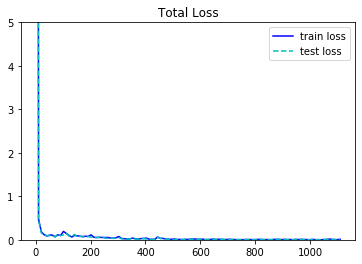

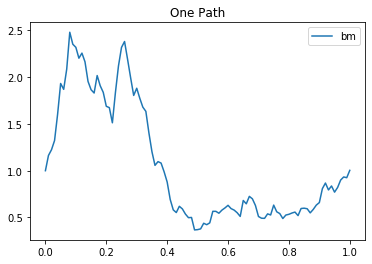

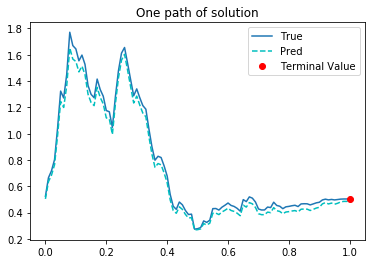

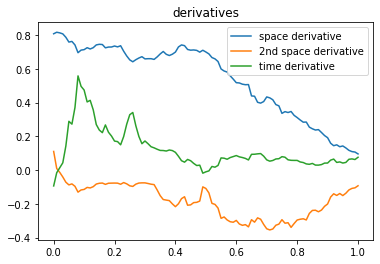

1111th Epoch:
traing loss is 0.0038255832623690367, test loss is 0.0030495792161673307, and learning rate is 0.006411709822714329, elapsed is 5.03039288520813.
 
1121th Epoch:
traing loss is 0.002392931841313839, test loss is 0.002674258081242442, and learning rate is 0.006411709822714329, elapsed is 4.327503681182861.
 
1131th Epoch:
traing loss is 0.0015000286512076855, test loss is 0.0015936490381136537, and learning rate is 0.006411709822714329, elapsed is 4.3634796142578125.
 
1141th Epoch:
traing loss is 0.004696417134255171, test loss is 0.004707487300038338, and learning rate is 0.006411709822714329, elapsed is 4.390542984008789.
 
1151th Epoch:
traing loss is 0.010187107138335705, test loss is 0.009491906501352787, and learning rate is 0.006283475551754236, elapsed is 4.2858641147613525.
 
1161th Epoch:
traing loss is 0.011164887808263302, test loss is 0.007871642708778381, and learning rate is 0.006283475551754236, elapsed is 4.312819004058838.
 
1171th Epoch:
traing loss is 

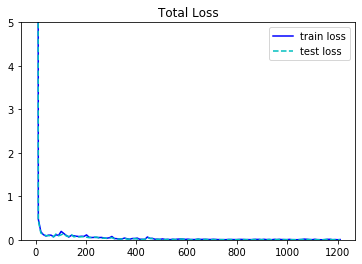

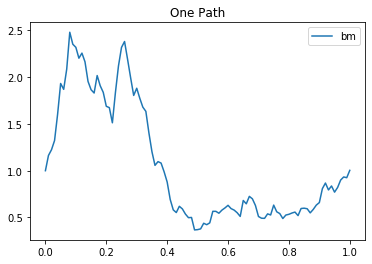

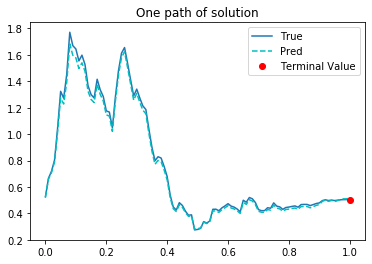

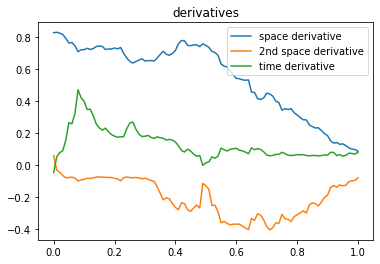

1211th Epoch:
traing loss is 0.002871967852115631, test loss is 0.0015756627544760704, and learning rate is 0.006157806608825922, elapsed is 5.0734031200408936.
 
1221th Epoch:
traing loss is 0.004445511847734451, test loss is 0.005045431666076183, and learning rate is 0.006157806608825922, elapsed is 4.2658371925354.
 
1231th Epoch:
traing loss is 0.0017117359675467014, test loss is 0.0017400303622707725, and learning rate is 0.006157806608825922, elapsed is 4.25469970703125.
 
1241th Epoch:
traing loss is 0.006998545955866575, test loss is 0.007901369594037533, and learning rate is 0.006157806608825922, elapsed is 4.275120258331299.
 
1251th Epoch:
traing loss is 0.0025484177749603987, test loss is 0.0022571254521608353, and learning rate is 0.006034649908542633, elapsed is 4.311915636062622.
 
1261th Epoch:
traing loss is 0.010421710088849068, test loss is 0.007436750922352076, and learning rate is 0.006034649908542633, elapsed is 4.261686325073242.
 
1271th Epoch:
traing loss is 0.

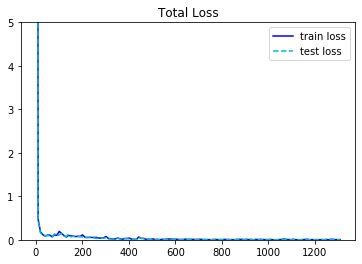

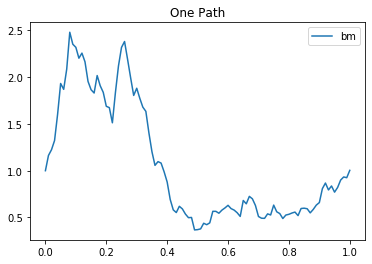

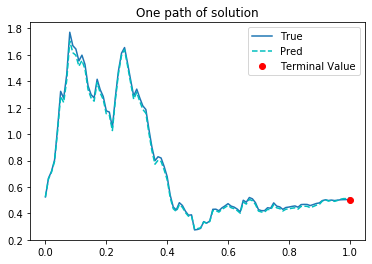

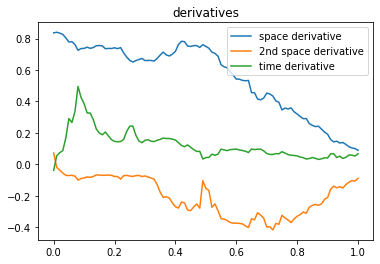

1311th Epoch:
traing loss is 0.006758589763194323, test loss is 0.0030814302153885365, and learning rate is 0.005913957022130489, elapsed is 5.141289472579956.
 
1321th Epoch:
traing loss is 0.005278102587908506, test loss is 0.006243198644369841, and learning rate is 0.005913957022130489, elapsed is 4.278874397277832.
 
1331th Epoch:
traing loss is 0.002458966337144375, test loss is 0.002614455297589302, and learning rate is 0.005913957022130489, elapsed is 4.301567554473877.
 
1341th Epoch:
traing loss is 0.008643442764878273, test loss is 0.009547553956508636, and learning rate is 0.005913957022130489, elapsed is 4.453854322433472.
 
1351th Epoch:
traing loss is 0.0031222300603985786, test loss is 0.003139830194413662, and learning rate is 0.005795678589493036, elapsed is 4.475224733352661.
 
1361th Epoch:
traing loss is 0.004046932328492403, test loss is 0.003267534775659442, and learning rate is 0.005795678589493036, elapsed is 4.35051703453064.
 
1371th Epoch:
traing loss is 0.00

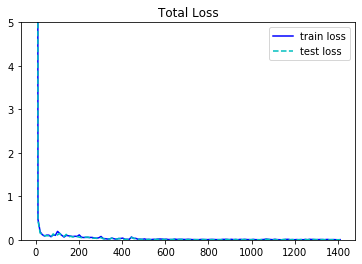

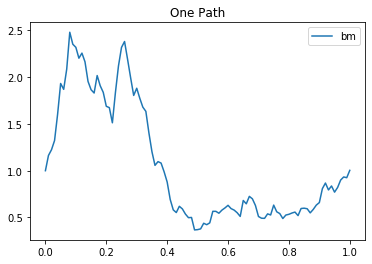

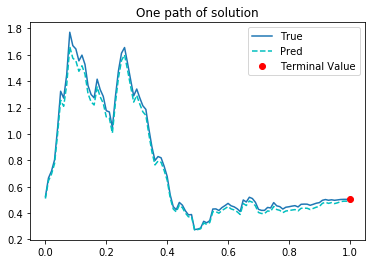

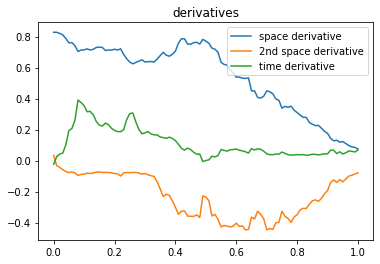

1411th Epoch:
traing loss is 0.003100004745647311, test loss is 0.00140064035076648, and learning rate is 0.005679764784872532, elapsed is 5.048335075378418.
 
1421th Epoch:
traing loss is 0.009074714034795761, test loss is 0.009364863857626915, and learning rate is 0.005679764784872532, elapsed is 4.319768667221069.
 
1431th Epoch:
traing loss is 0.0036653345450758934, test loss is 0.004027234390377998, and learning rate is 0.005679764784872532, elapsed is 4.284584045410156.
 
1441th Epoch:
traing loss is 0.004809100646525621, test loss is 0.00448221992701292, and learning rate is 0.005679764784872532, elapsed is 4.293918132781982.
 
1451th Epoch:
traing loss is 0.0020597807597368956, test loss is 0.001874336856417358, and learning rate is 0.005566169507801533, elapsed is 4.285048484802246.
 
1461th Epoch:
traing loss is 0.0044151549227535725, test loss is 0.004738226067274809, and learning rate is 0.005566169507801533, elapsed is 4.3177361488342285.
 
1471th Epoch:
traing loss is 0.0

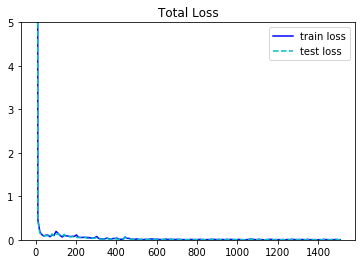

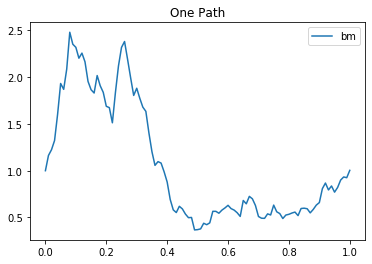

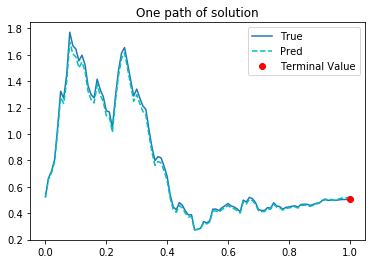

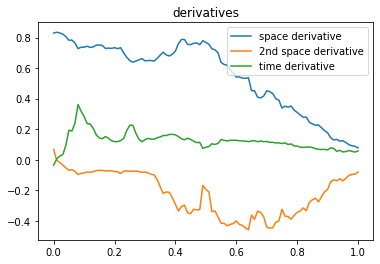

1511th Epoch:
traing loss is 0.0028476498555392027, test loss is 0.0018843284342437983, and learning rate is 0.005454846657812595, elapsed is 5.036666393280029.
 
1521th Epoch:
traing loss is 0.00487873749807477, test loss is 0.0057683344930410385, and learning rate is 0.005454846657812595, elapsed is 4.331886053085327.
 
1531th Epoch:
traing loss is 0.0017217987915500998, test loss is 0.0024069698993116617, and learning rate is 0.005454846657812595, elapsed is 4.35154914855957.
 
1541th Epoch:
traing loss is 0.0029905689880251884, test loss is 0.002498972462490201, and learning rate is 0.005454846657812595, elapsed is 4.394163131713867.
 
1551th Epoch:
traing loss is 0.0022157311905175447, test loss is 0.002057683654129505, and learning rate is 0.005345749203115702, elapsed is 4.325532913208008.
 
1561th Epoch:
traing loss is 0.005458604544401169, test loss is 0.005189025774598122, and learning rate is 0.005345749203115702, elapsed is 4.322260141372681.
 
1571th Epoch:
traing loss is 

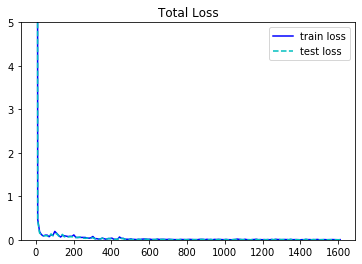

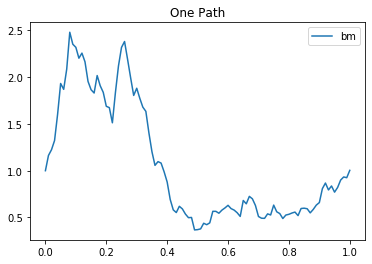

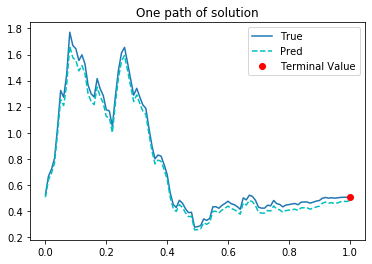

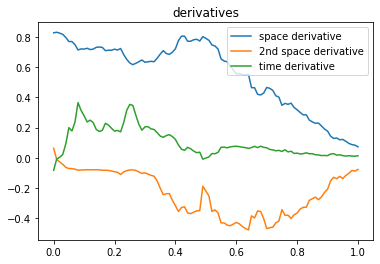

1611th Epoch:
traing loss is 0.0028300457634031773, test loss is 0.0017365522217005491, and learning rate is 0.005238834302872419, elapsed is 5.141521453857422.
 
1621th Epoch:
traing loss is 0.0020235017873346806, test loss is 0.0016461866907775402, and learning rate is 0.005238834302872419, elapsed is 4.266195058822632.
 
1631th Epoch:
traing loss is 0.002845721784979105, test loss is 0.003207179019227624, and learning rate is 0.005238834302872419, elapsed is 4.351272106170654.
 
1641th Epoch:
traing loss is 0.005136772524565458, test loss is 0.0031306634191423655, and learning rate is 0.005238834302872419, elapsed is 4.25850510597229.
 
1651th Epoch:
traing loss is 0.0019449383253231645, test loss is 0.001658142195083201, and learning rate is 0.005134057719260454, elapsed is 4.312300205230713.
 
1661th Epoch:
traing loss is 0.0020840936340391636, test loss is 0.0013679078547284007, and learning rate is 0.005134057719260454, elapsed is 4.324676513671875.
 
1671th Epoch:
traing loss i

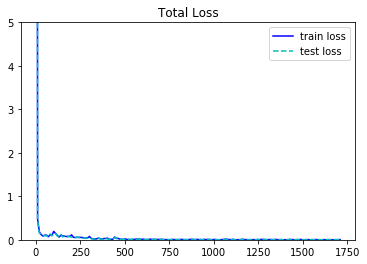

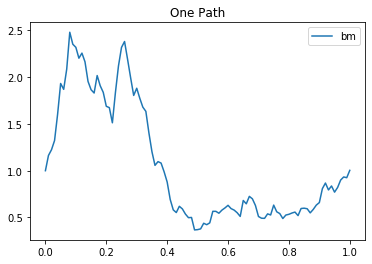

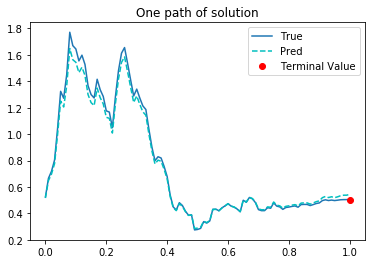

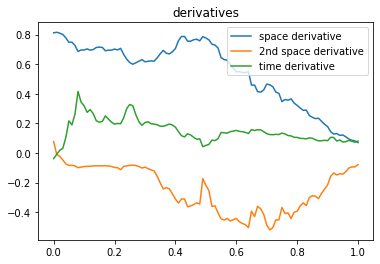

1711th Epoch:
traing loss is 0.0023527254816144705, test loss is 0.0018748188158497214, and learning rate is 0.005031377077102661, elapsed is 5.0264904499053955.
 
1721th Epoch:
traing loss is 0.0021719380747526884, test loss is 0.0025990421418100595, and learning rate is 0.005031377077102661, elapsed is 4.334299802780151.
 
1731th Epoch:
traing loss is 0.0017393685411661863, test loss is 0.0020012501627206802, and learning rate is 0.005031377077102661, elapsed is 4.335291147232056.
 
1741th Epoch:
traing loss is 0.0037318819668143988, test loss is 0.00367367803119123, and learning rate is 0.005031377077102661, elapsed is 4.306136608123779.
 
1751th Epoch:
traing loss is 0.002425279701128602, test loss is 0.00234614429064095, and learning rate is 0.004930749069899321, elapsed is 4.310904264450073.
 
1761th Epoch:
traing loss is 0.001872099470347166, test loss is 0.0014163288287818432, and learning rate is 0.004930749069899321, elapsed is 4.333549499511719.
 
1771th Epoch:
traing loss i

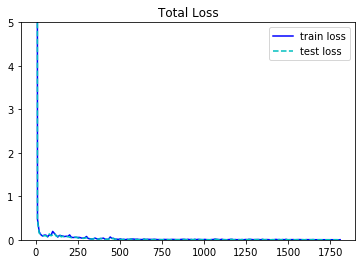

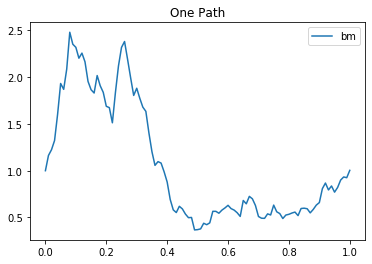

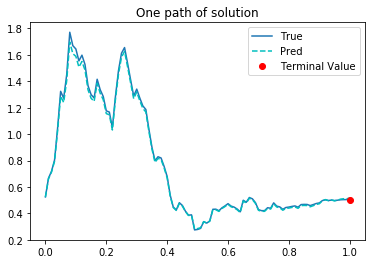

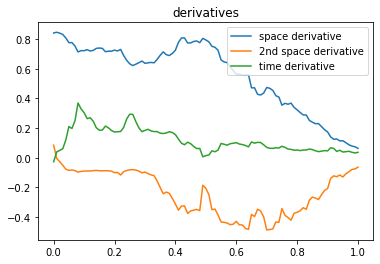

1811th Epoch:
traing loss is 0.0019957441836595535, test loss is 0.0011997245019301772, and learning rate is 0.004832134582102299, elapsed is 5.083379507064819.
 
1821th Epoch:
traing loss is 0.0013973780442029238, test loss is 0.001254801289178431, and learning rate is 0.004832134582102299, elapsed is 4.39497709274292.
 
1831th Epoch:
traing loss is 0.0013737655244767666, test loss is 0.0016553013119846582, and learning rate is 0.004832134582102299, elapsed is 4.3270909786224365.
 
1841th Epoch:
traing loss is 0.0022078785113990307, test loss is 0.001937350956723094, and learning rate is 0.004832134582102299, elapsed is 4.293733358383179.
 
1851th Epoch:
traing loss is 0.0015503624454140663, test loss is 0.0015667841071262956, and learning rate is 0.004735491704195738, elapsed is 4.3497700691223145.
 
1861th Epoch:
traing loss is 0.0030996568966656923, test loss is 0.002577777486294508, and learning rate is 0.004735491704195738, elapsed is 4.375257253646851.
 
1871th Epoch:
traing los

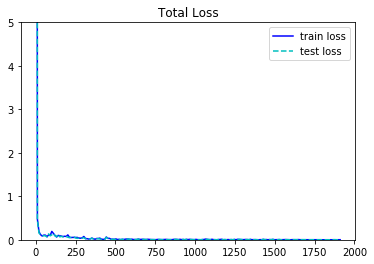

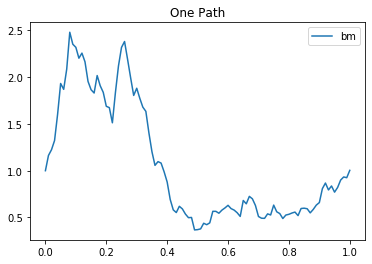

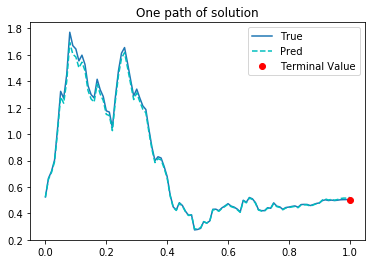

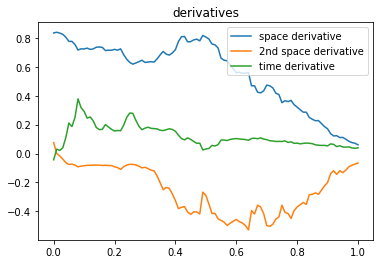

1911th Epoch:
traing loss is 0.001335278619080782, test loss is 0.0007658496615476906, and learning rate is 0.004640782251954079, elapsed is 5.058599472045898.
 
1921th Epoch:
traing loss is 0.0011675981804728508, test loss is 0.0010456761810928583, and learning rate is 0.004640782251954079, elapsed is 4.311908721923828.
 
1931th Epoch:
traing loss is 0.001255032722838223, test loss is 0.0015264308312907815, and learning rate is 0.004640782251954079, elapsed is 4.310190439224243.
 
1941th Epoch:
traing loss is 0.002504957839846611, test loss is 0.0023606077302247286, and learning rate is 0.004640782251954079, elapsed is 4.334165811538696.
 
1951th Epoch:
traing loss is 0.0023535198997706175, test loss is 0.0022805570624768734, and learning rate is 0.004547967109829187, elapsed is 4.332252264022827.
 
1961th Epoch:
traing loss is 0.0025806522462517023, test loss is 0.00249934708699584, and learning rate is 0.004547967109829187, elapsed is 4.416877031326294.
 
1971th Epoch:
traing loss i

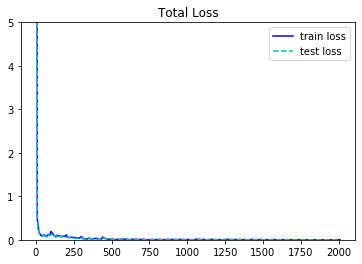

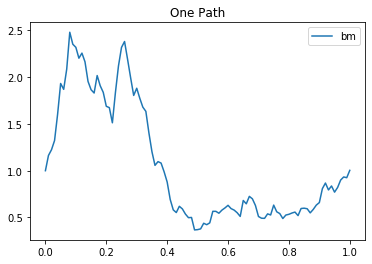

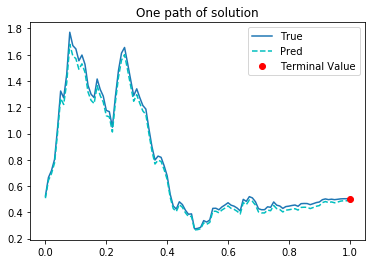

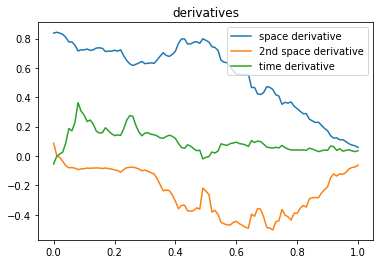

2011th Epoch:
traing loss is 0.0016428119270130992, test loss is 0.0008778375922702253, and learning rate is 0.00445700716227293, elapsed is 5.05636191368103.
 
2021th Epoch:
traing loss is 0.002348138950765133, test loss is 0.00278930994682014, and learning rate is 0.00445700716227293, elapsed is 4.489507436752319.
 
2031th Epoch:
traing loss is 0.0019165260018780828, test loss is 0.002172275213524699, and learning rate is 0.00445700716227293, elapsed is 4.4644856452941895.
 
2041th Epoch:
traing loss is 0.002034388715401292, test loss is 0.002083305036649108, and learning rate is 0.00445700716227293, elapsed is 4.385613441467285.
 
2051th Epoch:
traing loss is 0.0011471821926534176, test loss is 0.0012149526737630367, and learning rate is 0.004367867484688759, elapsed is 4.405401229858398.
 
2061th Epoch:
traing loss is 0.0014499538810923696, test loss is 0.0013435190776363015, and learning rate is 0.004367867484688759, elapsed is 4.311428070068359.
 
2071th Epoch:
traing loss is 0.0

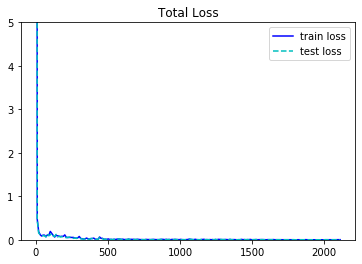

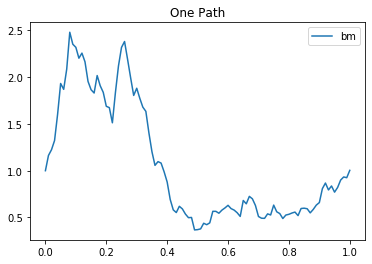

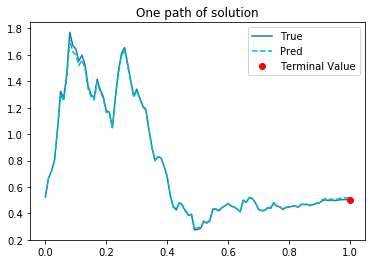

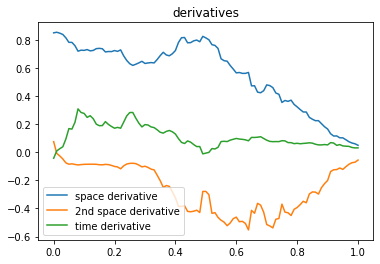

2111th Epoch:
traing loss is 0.00166254339274019, test loss is 0.0010334764374420047, and learning rate is 0.004280509892851114, elapsed is 5.108174562454224.
 
2121th Epoch:
traing loss is 0.001307266647927463, test loss is 0.0011726761003956199, and learning rate is 0.004280509892851114, elapsed is 4.3464624881744385.
 
2131th Epoch:
traing loss is 0.0008511996129527688, test loss is 0.0010852187406271696, and learning rate is 0.004280509892851114, elapsed is 4.280267238616943.
 
2141th Epoch:
traing loss is 0.00221945415250957, test loss is 0.0019041928462684155, and learning rate is 0.004280509892851114, elapsed is 4.28170371055603.
 
2151th Epoch:
traing loss is 0.003261503530666232, test loss is 0.002990140812471509, and learning rate is 0.004194899927824736, elapsed is 4.475549697875977.
 
2161th Epoch:
traing loss is 0.0029469027649611235, test loss is 0.002829289995133877, and learning rate is 0.004194899927824736, elapsed is 4.388811111450195.
 
2171th Epoch:
traing loss is 0

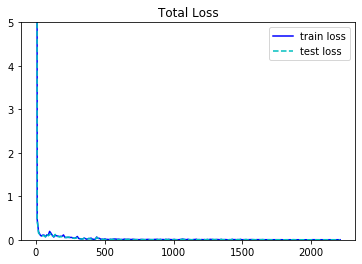

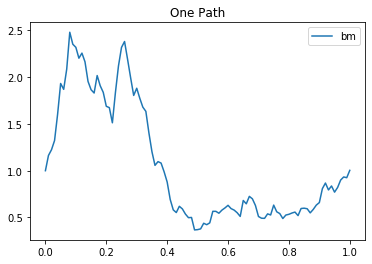

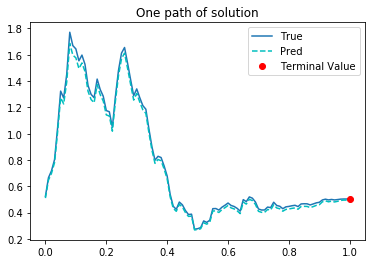

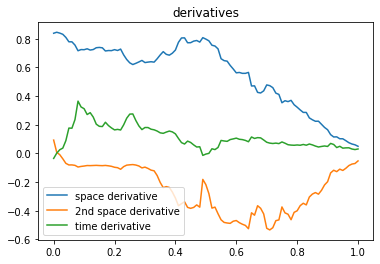

2211th Epoch:
traing loss is 0.001509442343376577, test loss is 0.0009581070626154542, and learning rate is 0.004111002199351788, elapsed is 5.171652555465698.
 
2221th Epoch:
traing loss is 0.001778295962139964, test loss is 0.001640599686652422, and learning rate is 0.004111002199351788, elapsed is 4.398080110549927.
 
2231th Epoch:
traing loss is 0.0014924370916560292, test loss is 0.0017283642664551735, and learning rate is 0.004111002199351788, elapsed is 4.365128993988037.
 
2241th Epoch:
traing loss is 0.002831327263265848, test loss is 0.002868975978344679, and learning rate is 0.004111002199351788, elapsed is 4.320404767990112.
 
2251th Epoch:
traing loss is 0.0015788747696205974, test loss is 0.0015343227423727512, and learning rate is 0.004028781782835722, elapsed is 4.340507745742798.
 
2261th Epoch:
traing loss is 0.0028723268769681454, test loss is 0.00239234184846282, and learning rate is 0.004028781782835722, elapsed is 4.308486461639404.
 
2271th Epoch:
traing loss is 

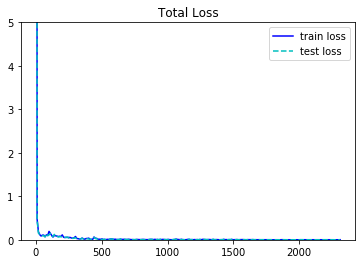

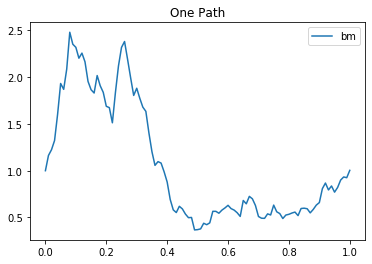

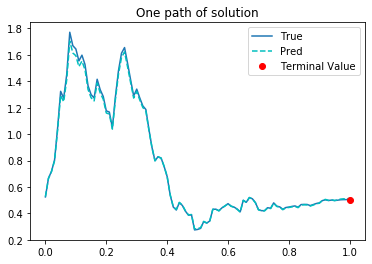

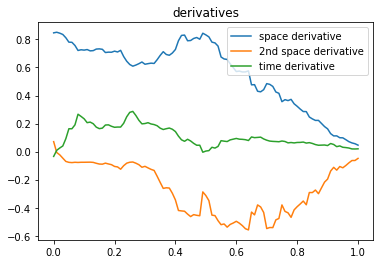

2311th Epoch:
traing loss is 0.0009664105018600821, test loss is 0.0006853408413007855, and learning rate is 0.003948206547647715, elapsed is 5.060985088348389.
 
2321th Epoch:
traing loss is 0.0014782974030822515, test loss is 0.001237133052200079, and learning rate is 0.003948206547647715, elapsed is 4.394703149795532.
 
2331th Epoch:
traing loss is 0.0007877995958551764, test loss is 0.0009683400276117027, and learning rate is 0.003948206547647715, elapsed is 4.343963623046875.
 
2341th Epoch:
traing loss is 0.0022163703106343746, test loss is 0.002001543529331684, and learning rate is 0.003948206547647715, elapsed is 4.363329172134399.
 
2351th Epoch:
traing loss is 0.0015063965693116188, test loss is 0.0013977381167933345, and learning rate is 0.0038692422676831484, elapsed is 4.323366641998291.
 
2361th Epoch:
traing loss is 0.0014048708835616708, test loss is 0.0011830945732071996, and learning rate is 0.0038692422676831484, elapsed is 4.329011678695679.
 
2371th Epoch:
traing l

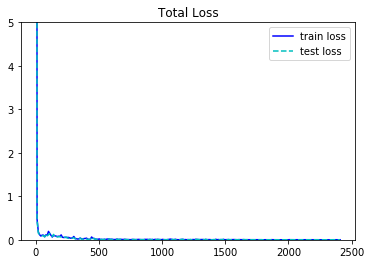

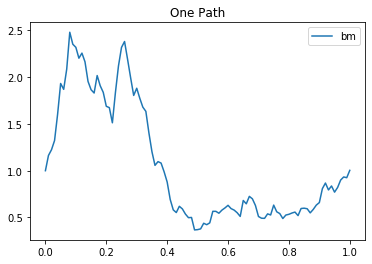

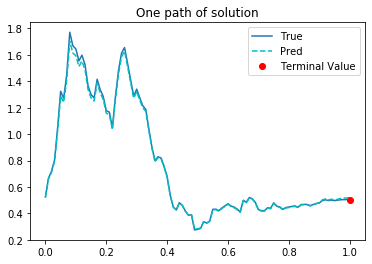

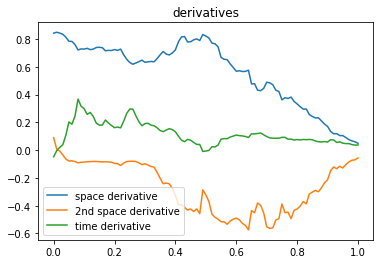

2411th Epoch:
traing loss is 0.0010865507647395134, test loss is 0.0007201362168416381, and learning rate is 0.00379185751080513, elapsed is 5.109149694442749.
 
2421th Epoch:
traing loss is 0.0012046954361721873, test loss is 0.001004597870633006, and learning rate is 0.00379185751080513, elapsed is 4.3689775466918945.
 
2431th Epoch:
traing loss is 0.0009112522238865495, test loss is 0.0011535414960235357, and learning rate is 0.00379185751080513, elapsed is 4.425203561782837.
 
2441th Epoch:
traing loss is 0.0012180639896541834, test loss is 0.001045801443979144, and learning rate is 0.00379185751080513, elapsed is 4.317066192626953.
 
2451th Epoch:
traing loss is 0.0011126203462481499, test loss is 0.0010886441450566053, and learning rate is 0.0037160206120461226, elapsed is 4.318661212921143.
 
2461th Epoch:
traing loss is 0.0013870449038222432, test loss is 0.0013323642779141665, and learning rate is 0.0037160206120461226, elapsed is 4.331527948379517.
 
2471th Epoch:
traing loss

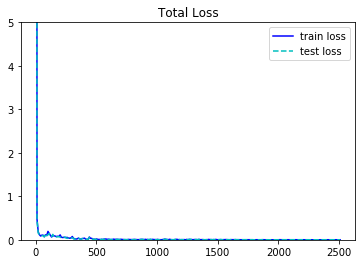

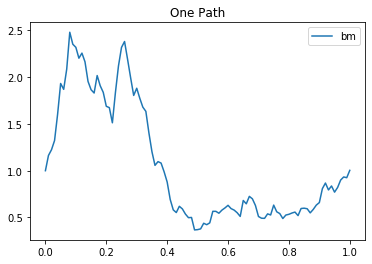

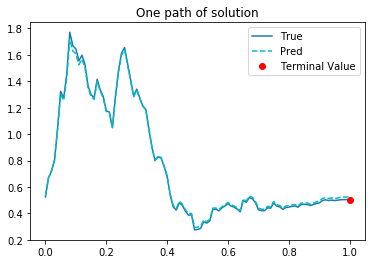

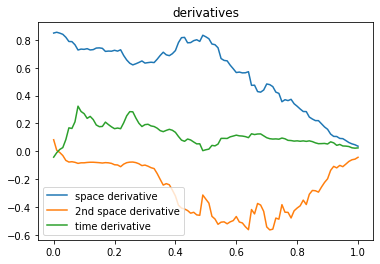

2511th Epoch:
traing loss is 0.0008767793187871575, test loss is 0.0005761770880781114, and learning rate is 0.0036417001392692327, elapsed is 5.701918363571167.
 
2521th Epoch:
traing loss is 0.0009295333875343204, test loss is 0.0008857777575030923, and learning rate is 0.0036417001392692327, elapsed is 4.362329006195068.
 
2531th Epoch:
traing loss is 0.000903572014067322, test loss is 0.0011858028592541814, and learning rate is 0.0036417001392692327, elapsed is 4.367236375808716.
 
2541th Epoch:
traing loss is 0.0014162728330120444, test loss is 0.00126791896764189, and learning rate is 0.0036417001392692327, elapsed is 4.440701246261597.
 
2551th Epoch:
traing loss is 0.002085844986140728, test loss is 0.001988189062103629, and learning rate is 0.0035688665229827166, elapsed is 4.458653211593628.
 
2561th Epoch:
traing loss is 0.0017625695327296853, test loss is 0.001748743001371622, and learning rate is 0.0035688665229827166, elapsed is 4.494794607162476.
 
2571th Epoch:
traing l

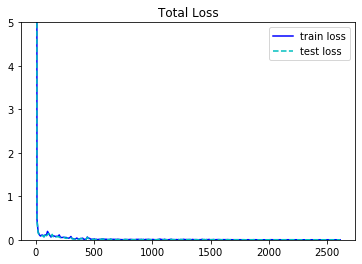

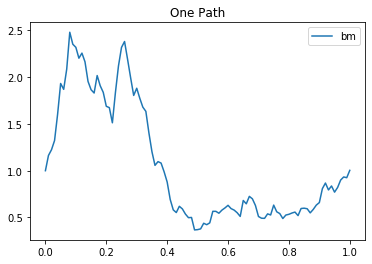

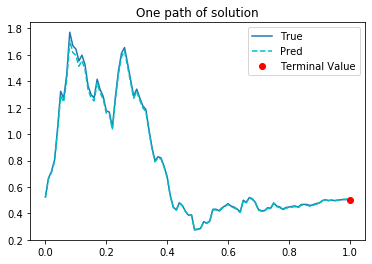

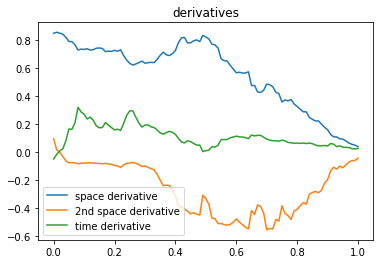

2611th Epoch:
traing loss is 0.0008750788401812315, test loss is 0.0005425023846328259, and learning rate is 0.0034974890295416117, elapsed is 5.077227354049683.
 
2621th Epoch:
traing loss is 0.0009084772318601608, test loss is 0.0007987089920789003, and learning rate is 0.0034974890295416117, elapsed is 4.5006091594696045.
 
2631th Epoch:
traing loss is 0.0007369531667791307, test loss is 0.000943696650210768, and learning rate is 0.0034974890295416117, elapsed is 4.623701333999634.
 
2641th Epoch:
traing loss is 0.0006673724856227636, test loss is 0.0006023801979608834, and learning rate is 0.0034974890295416117, elapsed is 4.505622148513794.
 
2651th Epoch:
traing loss is 0.001467157038860023, test loss is 0.0014268377562984824, and learning rate is 0.0034275390207767487, elapsed is 4.405458211898804.
 
2661th Epoch:
traing loss is 0.0013548360439017415, test loss is 0.0013286698376759887, and learning rate is 0.0034275390207767487, elapsed is 4.420254230499268.
 
2671th Epoch:
tra

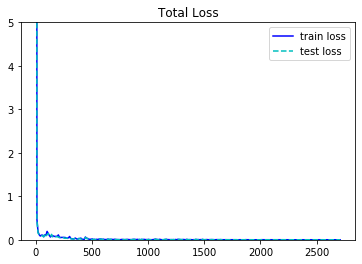

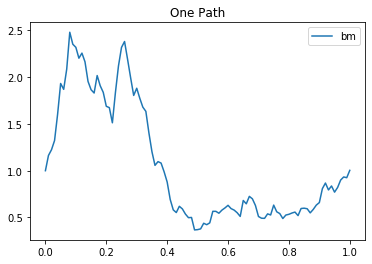

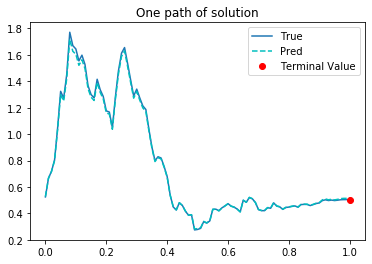

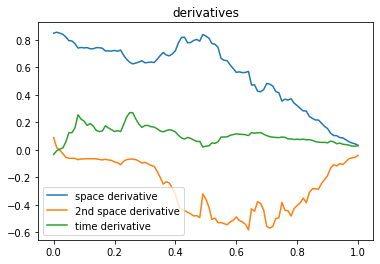

2711th Epoch:
traing loss is 0.0007705683237873018, test loss is 0.0005351523868739605, and learning rate is 0.0033589887898415327, elapsed is 5.1070287227630615.
 
2721th Epoch:
traing loss is 0.0005894888890907168, test loss is 0.0006231162697076797, and learning rate is 0.0033589887898415327, elapsed is 4.4415810108184814.
 
2731th Epoch:
traing loss is 0.0006192869041115046, test loss is 0.0008113045478239655, and learning rate is 0.0033589887898415327, elapsed is 4.395164966583252.
 
2741th Epoch:
traing loss is 0.0012811495689675212, test loss is 0.001243598642759025, and learning rate is 0.0033589887898415327, elapsed is 4.392240047454834.
 
2751th Epoch:
traing loss is 0.002382211619988084, test loss is 0.0022105604875832796, and learning rate is 0.0032918090000748634, elapsed is 4.434877395629883.
 
2761th Epoch:
traing loss is 0.0011734600411728024, test loss is 0.001065657939761877, and learning rate is 0.0032918090000748634, elapsed is 4.428708791732788.
 
2771th Epoch:
tra

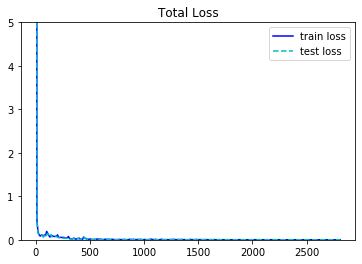

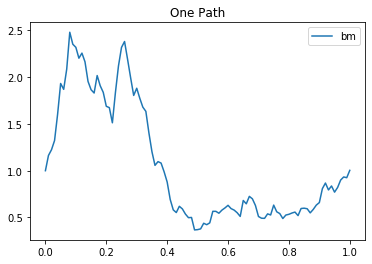

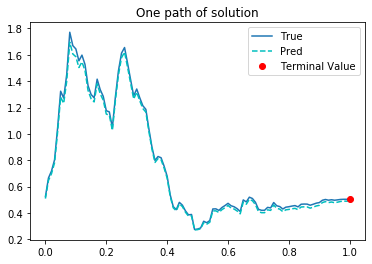

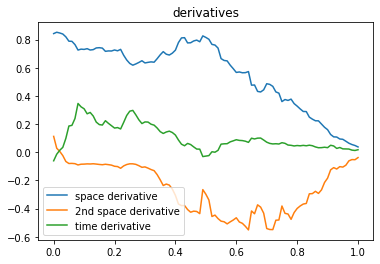

2811th Epoch:
traing loss is 0.0009000826394185424, test loss is 0.0005957641988061368, and learning rate is 0.0032259728759527206, elapsed is 5.114746332168579.
 
2821th Epoch:
traing loss is 0.0010933653684332967, test loss is 0.0010605498682707548, and learning rate is 0.0032259728759527206, elapsed is 4.451912879943848.
 
2831th Epoch:
traing loss is 0.0009560302714817226, test loss is 0.0011873521143570542, and learning rate is 0.0032259728759527206, elapsed is 4.4012672901153564.
 
2841th Epoch:
traing loss is 0.0019338864367455244, test loss is 0.0019601406529545784, and learning rate is 0.0032259728759527206, elapsed is 4.368593215942383.
 
2851th Epoch:
traing loss is 0.0007338251452893019, test loss is 0.0007270798669196665, and learning rate is 0.003161453176289797, elapsed is 4.426065921783447.
 
2861th Epoch:
traing loss is 0.0005099365371279418, test loss is 0.00038812760612927377, and learning rate is 0.003161453176289797, elapsed is 4.3769731521606445.
 
2871th Epoch:
t

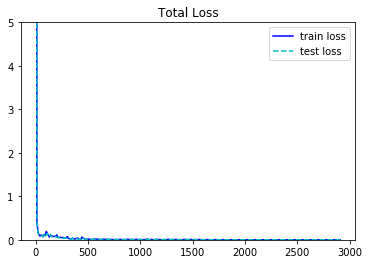

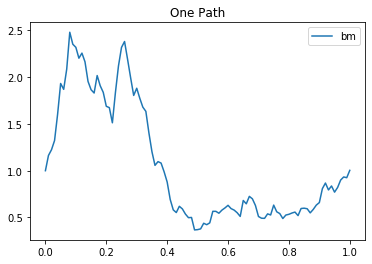

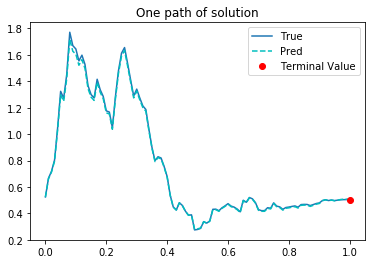

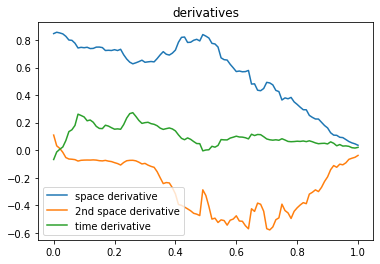

2911th Epoch:
traing loss is 0.0007883211364969611, test loss is 0.000508482800796628, and learning rate is 0.00309822428971529, elapsed is 5.142631769180298.
 
2921th Epoch:
traing loss is 0.0004919216153211892, test loss is 0.0005001549143344164, and learning rate is 0.00309822428971529, elapsed is 4.392366647720337.
 
2931th Epoch:
traing loss is 0.0004460378841031343, test loss is 0.0005919857067056, and learning rate is 0.00309822428971529, elapsed is 4.374233961105347.
 
2941th Epoch:
traing loss is 0.0028672886546701193, test loss is 0.002837360603734851, and learning rate is 0.00309822428971529, elapsed is 4.391985654830933.
 
2951th Epoch:
traing loss is 0.0033918239641934633, test loss is 0.003164393827319145, and learning rate is 0.0030362599063664675, elapsed is 4.38965630531311.
 
2961th Epoch:
traing loss is 0.0017438281793147326, test loss is 0.0020279870368540287, and learning rate is 0.0030362599063664675, elapsed is 4.407405853271484.
 
2971th Epoch:
traing loss is 0.

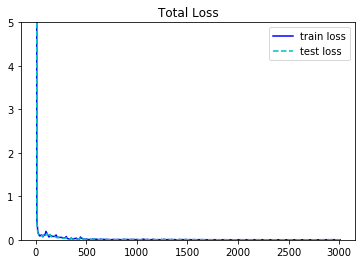

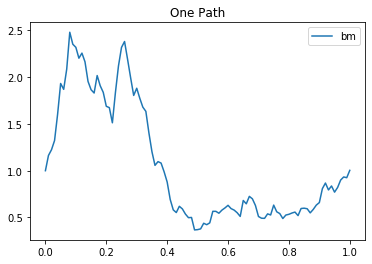

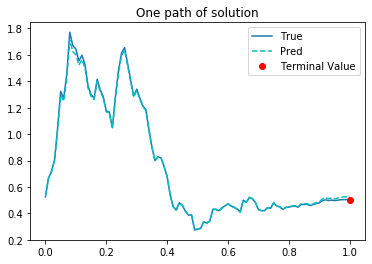

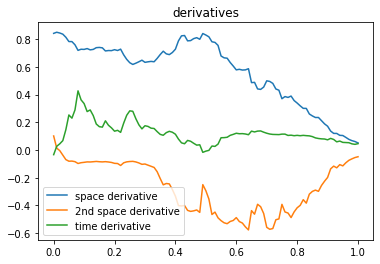

3011th Epoch:
traing loss is 0.0017098316457122564, test loss is 0.0013084359234198928, and learning rate is 0.0029755346477031708, elapsed is 5.112457513809204.
 
3021th Epoch:
traing loss is 0.0008379771606996655, test loss is 0.0008355886675417423, and learning rate is 0.0029755346477031708, elapsed is 4.408938646316528.
 
3031th Epoch:
traing loss is 0.001525399973616004, test loss is 0.0016813287511467934, and learning rate is 0.0029755346477031708, elapsed is 4.359949111938477.
 
3041th Epoch:
traing loss is 0.0014614552492275834, test loss is 0.0013024546205997467, and learning rate is 0.0029755346477031708, elapsed is 4.357675790786743.
 
3051th Epoch:
traing loss is 0.0010800102027133107, test loss is 0.0010315529070794582, and learning rate is 0.00291602429933846, elapsed is 4.39360499382019.
 
3061th Epoch:
traing loss is 0.001821177895180881, test loss is 0.001594398869201541, and learning rate is 0.00291602429933846, elapsed is 4.379530191421509.
 
3071th Epoch:
traing los

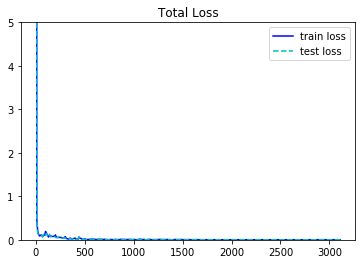

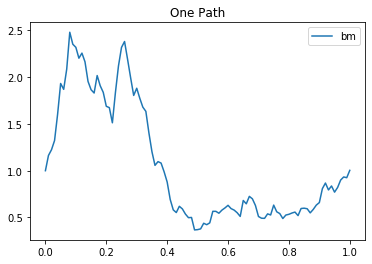

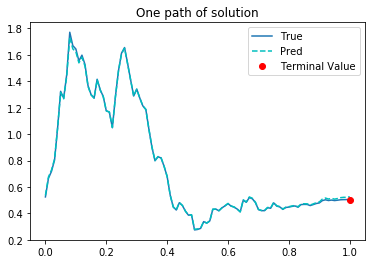

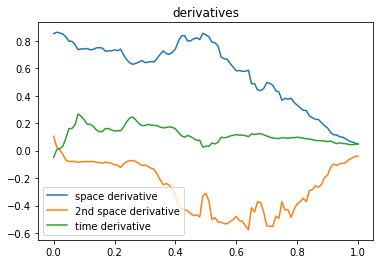

3111th Epoch:
traing loss is 0.001794199924916029, test loss is 0.0014088958268985152, and learning rate is 0.0028577034827321768, elapsed is 5.097944259643555.
 
3121th Epoch:
traing loss is 0.0010852399282157421, test loss is 0.0009167814860120416, and learning rate is 0.0028577034827321768, elapsed is 4.380824327468872.
 
3131th Epoch:
traing loss is 0.0014443839900195599, test loss is 0.001580757088959217, and learning rate is 0.0028577034827321768, elapsed is 4.415925979614258.
 
3141th Epoch:
traing loss is 0.0015920433215796947, test loss is 0.001528513734228909, and learning rate is 0.0028577034827321768, elapsed is 4.3735175132751465.
 
3151th Epoch:
traing loss is 0.0006374877411872149, test loss is 0.0006235068431124091, and learning rate is 0.002800549613311887, elapsed is 4.398214340209961.
 
3161th Epoch:
traing loss is 0.002627332229167223, test loss is 0.0011151625076308846, and learning rate is 0.002800549613311887, elapsed is 4.373267889022827.
 
3171th Epoch:
traing 

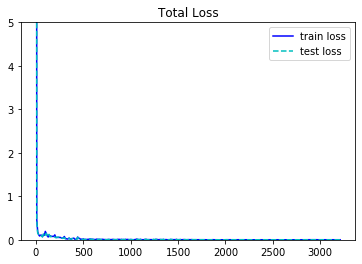

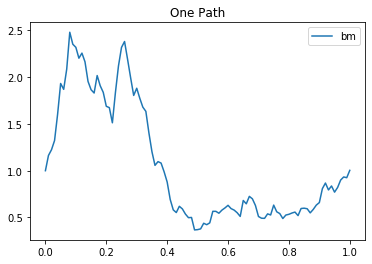

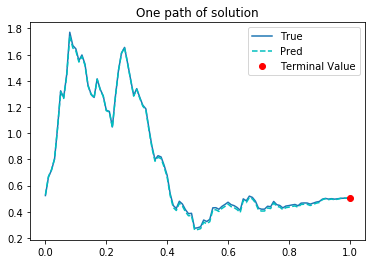

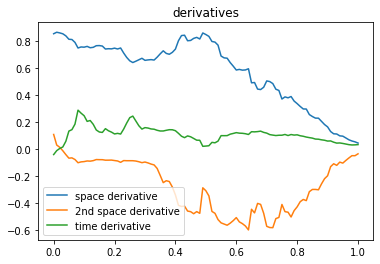

3211th Epoch:
traing loss is 0.0014756363816559315, test loss is 0.0006334917270578444, and learning rate is 0.0027445387095212936, elapsed is 5.107246398925781.
 
3221th Epoch:
traing loss is 0.0016054075676947832, test loss is 0.0019222918199375272, and learning rate is 0.0027445387095212936, elapsed is 4.40930962562561.
 
3231th Epoch:
traing loss is 0.0008045812137424946, test loss is 0.0010229172185063362, and learning rate is 0.0027445387095212936, elapsed is 4.51066780090332.
 
3241th Epoch:
traing loss is 0.0015827770112082362, test loss is 0.001455275691114366, and learning rate is 0.0027445387095212936, elapsed is 4.435192584991455.
 
3251th Epoch:
traing loss is 0.00103557703550905, test loss is 0.0009258504142053425, and learning rate is 0.0026896479539573193, elapsed is 4.44073486328125.
 
3261th Epoch:
traing loss is 0.0030424287542700768, test loss is 0.002085884800180793, and learning rate is 0.0026896479539573193, elapsed is 4.443492412567139.
 
3271th Epoch:
traing lo

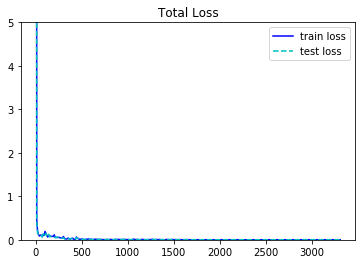

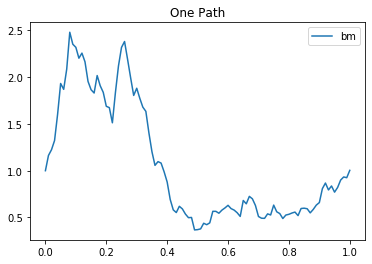

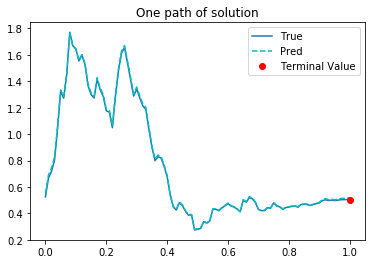

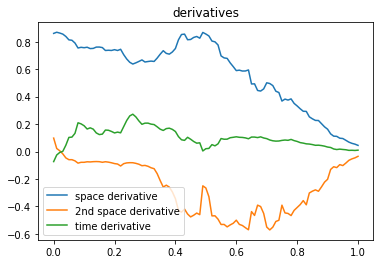

3311th Epoch:
traing loss is 0.0011425204575061798, test loss is 0.0005929719773121178, and learning rate is 0.0026358552277088165, elapsed is 5.058416843414307.
 
3321th Epoch:
traing loss is 0.0019405643688514829, test loss is 0.0019466094672679901, and learning rate is 0.0026358552277088165, elapsed is 4.400920629501343.
 
3331th Epoch:
traing loss is 0.0010406628716737032, test loss is 0.0012927335919812322, and learning rate is 0.0026358552277088165, elapsed is 4.461522817611694.
 
3341th Epoch:
traing loss is 0.002153830137103796, test loss is 0.001536175492219627, and learning rate is 0.0026358552277088165, elapsed is 4.398904800415039.
 
3351th Epoch:
traing loss is 0.0009282489190809429, test loss is 0.000774829532019794, and learning rate is 0.002583137946203351, elapsed is 4.432662725448608.
 
3361th Epoch:
traing loss is 0.002867545001208782, test loss is 0.0017318582395091653, and learning rate is 0.002583137946203351, elapsed is 4.50391411781311.
 
3371th Epoch:
traing lo

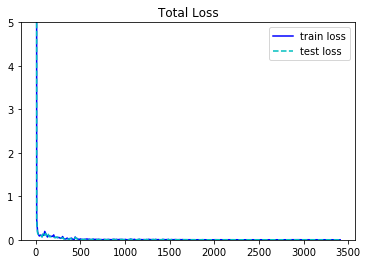

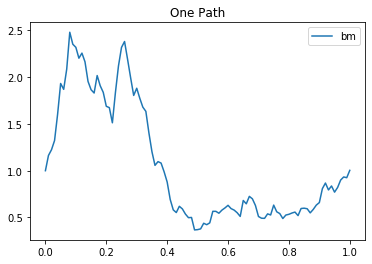

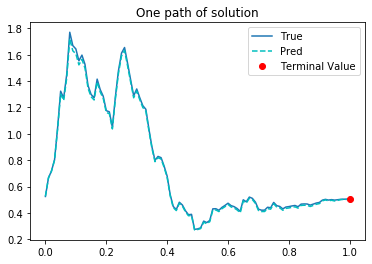

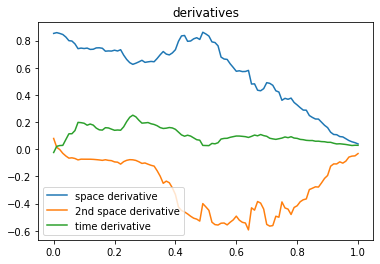

3411th Epoch:
traing loss is 0.0010117539204657078, test loss is 0.0007880987250246108, and learning rate is 0.0025314753875136375, elapsed is 5.207372665405273.
 
3421th Epoch:
traing loss is 0.0014085215516388416, test loss is 0.0016495564486831427, and learning rate is 0.0025314753875136375, elapsed is 4.491641521453857.
 
3431th Epoch:
traing loss is 0.0006339239189401269, test loss is 0.0008564993040636182, and learning rate is 0.0025314753875136375, elapsed is 4.421438217163086.
 
3441th Epoch:
traing loss is 0.0010310356738045812, test loss is 0.0009328541345894337, and learning rate is 0.0025314753875136375, elapsed is 4.3911943435668945.
 
3451th Epoch:
traing loss is 0.00047721140435896814, test loss is 0.00046004701289348304, and learning rate is 0.0024808458983898163, elapsed is 4.3879523277282715.
 
3461th Epoch:
traing loss is 0.0015569032402709126, test loss is 0.0012797943782061338, and learning rate is 0.0024808458983898163, elapsed is 4.352970123291016.
 
3471th Epoch

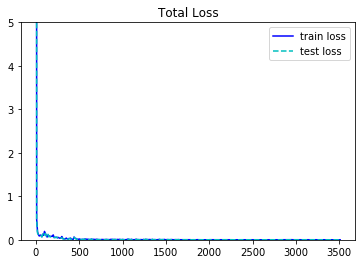

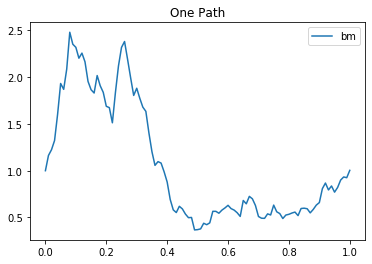

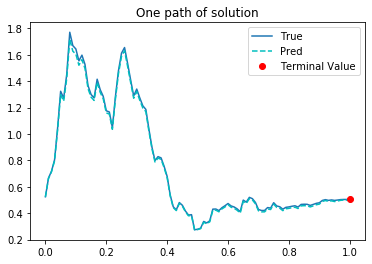

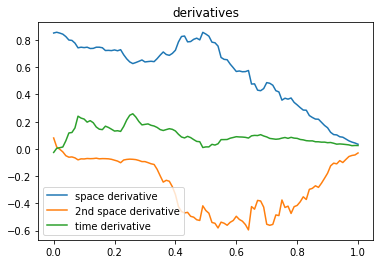

3511th Epoch:
traing loss is 0.0008207062492147088, test loss is 0.0006817574612796307, and learning rate is 0.0024312289897352457, elapsed is 5.111523628234863.
 
3521th Epoch:
traing loss is 0.0011939727701246738, test loss is 0.0014091201592236757, and learning rate is 0.0024312289897352457, elapsed is 4.424939393997192.
 
3531th Epoch:
traing loss is 0.0005130559438839555, test loss is 0.0007136110798455775, and learning rate is 0.0024312289897352457, elapsed is 4.372250556945801.
 
3541th Epoch:
traing loss is 0.0010126271517947316, test loss is 0.0007862597703933716, and learning rate is 0.0024312289897352457, elapsed is 4.371801376342773.
 
3551th Epoch:
traing loss is 0.0005779177299700677, test loss is 0.0005795860779471695, and learning rate is 0.002382604405283928, elapsed is 4.403240203857422.
 
3561th Epoch:
traing loss is 0.00095147400861606, test loss is 0.000935186049900949, and learning rate is 0.002382604405283928, elapsed is 4.370621681213379.
 
3571th Epoch:
traing 

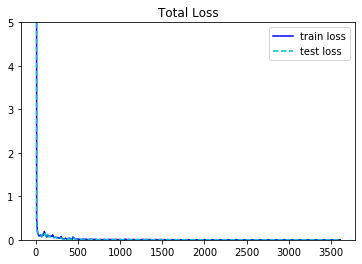

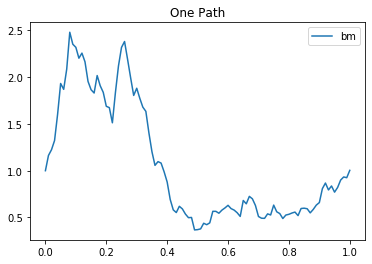

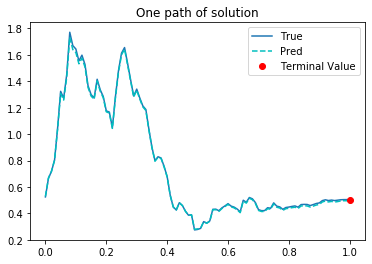

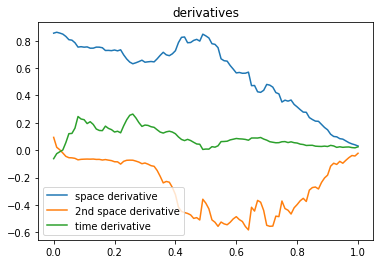

3611th Epoch:
traing loss is 0.0008744096267037094, test loss is 0.0006874176906421781, and learning rate is 0.0023349523544311523, elapsed is 5.135716915130615.
 
3621th Epoch:
traing loss is 0.001595927868038416, test loss is 0.0017910609021782875, and learning rate is 0.0023349523544311523, elapsed is 4.376121997833252.
 
3631th Epoch:
traing loss is 0.0007597492076456547, test loss is 0.001046994817443192, and learning rate is 0.0023349523544311523, elapsed is 4.439969301223755.
 
3641th Epoch:
traing loss is 0.0006959812599234283, test loss is 0.000712613807991147, and learning rate is 0.0023349523544311523, elapsed is 4.402387619018555.
 
3651th Epoch:
traing loss is 0.000524854869581759, test loss is 0.0004996428033336997, and learning rate is 0.002288253279402852, elapsed is 4.3956522941589355.
 
3661th Epoch:
traing loss is 0.0005261224578134716, test loss is 0.000334427721099928, and learning rate is 0.002288253279402852, elapsed is 4.358839750289917.
 
3671th Epoch:
traing l

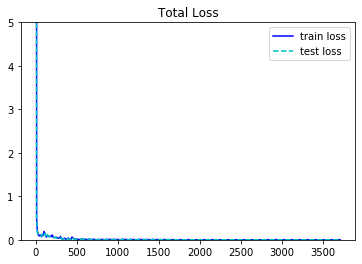

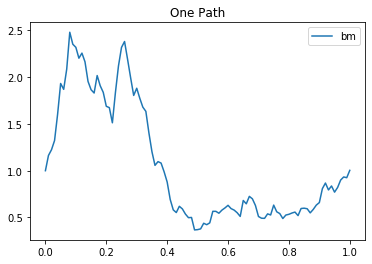

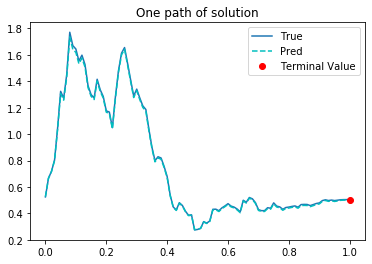

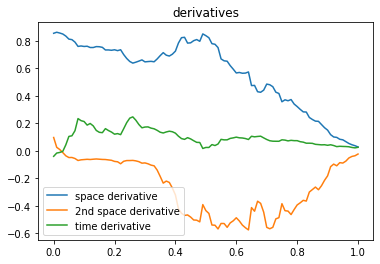

3711th Epoch:
traing loss is 0.0005617187707684934, test loss is 0.00045448646415024996, and learning rate is 0.002242488320916891, elapsed is 5.130765914916992.
 
3721th Epoch:
traing loss is 0.0006137429154478014, test loss is 0.0007160252425819635, and learning rate is 0.002242488320916891, elapsed is 4.380518198013306.
 
3731th Epoch:
traing loss is 0.0002424518606858328, test loss is 0.00032786562223918736, and learning rate is 0.002242488320916891, elapsed is 4.437872886657715.
 
3741th Epoch:
traing loss is 0.0006448469939641654, test loss is 0.0005896638031117618, and learning rate is 0.002242488320916891, elapsed is 4.40058708190918.
 
3751th Epoch:
traing loss is 0.00047154157073237, test loss is 0.00046226338599808514, and learning rate is 0.0021976386196911335, elapsed is 4.49127984046936.
 
3761th Epoch:
traing loss is 0.0005588959320448339, test loss is 0.0005415386985987425, and learning rate is 0.0021976386196911335, elapsed is 5.154811143875122.
 
3771th Epoch:
traing 

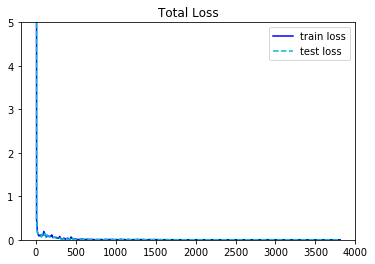

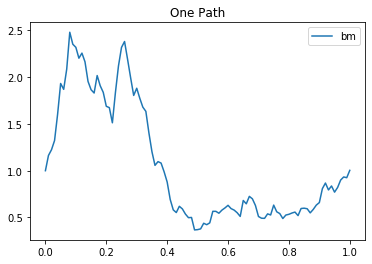

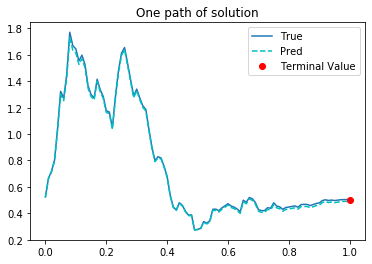

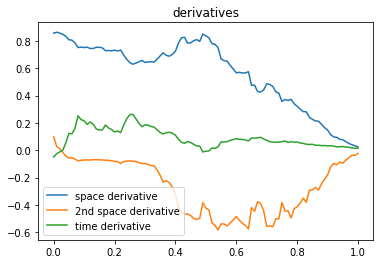

3811th Epoch:
traing loss is 0.0005770704010501504, test loss is 0.000502338632941246, and learning rate is 0.0021536860149353743, elapsed is 5.119986295700073.
 
3821th Epoch:
traing loss is 0.0004921848885715008, test loss is 0.0005440125241875648, and learning rate is 0.0021536860149353743, elapsed is 4.39244532585144.
 
3831th Epoch:
traing loss is 0.00021414451475720853, test loss is 0.0002832565223798156, and learning rate is 0.0021536860149353743, elapsed is 4.438507795333862.
 
3841th Epoch:
traing loss is 0.0007100239163264632, test loss is 0.0006950880051590502, and learning rate is 0.0021536860149353743, elapsed is 4.3406453132629395.
 
3851th Epoch:
traing loss is 0.0005278501776047051, test loss is 0.0004400578036438674, and learning rate is 0.0021106123458594084, elapsed is 4.333213806152344.
 
3861th Epoch:
traing loss is 0.0005813759635202587, test loss is 0.0003771737974602729, and learning rate is 0.0021106123458594084, elapsed is 4.346400499343872.
 
3871th Epoch:
tr

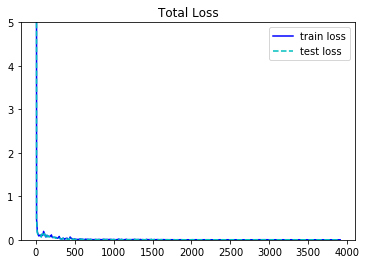

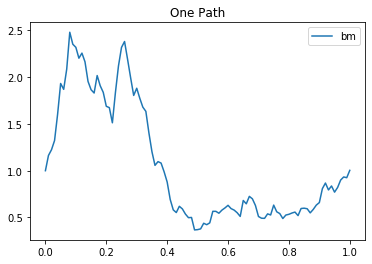

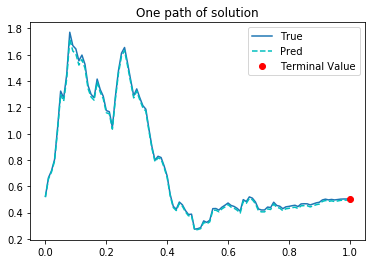

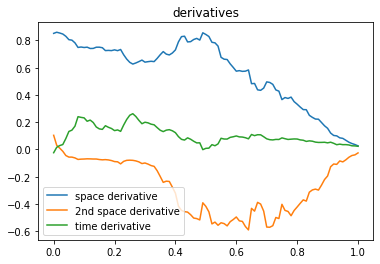

3911th Epoch:
traing loss is 0.000669877917971462, test loss is 0.0004907884285785258, and learning rate is 0.002068400150164962, elapsed is 5.253860712051392.
 


In [0]:
start_time = ttt.time()

for it in range(Epoch):
    seed = it % 100
    path_feed =  Create_paths(seed, M)
    feed_dict = {path: path_feed, time: time_feed}
    sess.run(train_op, feed_dict)

    if (it % 10 == 0): # every 10 epoch print and record
        elapsed = ttt.time() - start_time
        print("{}th Epoch:".format(it+1))
        loss_value = sess.run(loss, feed_dict)
        lr = sess.run(learning_rate)
        loss_test = sess.run(loss, pred_dict)
        print("traing loss is {}, test loss is {}, and learning rate is {}, elapsed is {}.".format(loss_value, loss_test, lr, elapsed))
        print(" ")

        train_loss_list.append(loss_value)
        test_loss_list.append(loss_test)        
        start_time = ttt.time()

    if (it % 100 == 0): # every 100 epoch, show picture

        solution_pred, time_derivative_pred, space_derivative_pred, space_2nd_derivative_pred = sess.run([solution, time_derivative, space_derivative, space_2nd_derivative], pred_dict)
        num_epoches = len(train_loss_list)
        x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)

        # plot train/test loss 
        plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "train loss")
        plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "test loss")
        plt.legend()
        plt.ylim([0, 0.1])
        plt.title("Total Loss")
        plt.show()
        
        # plot one example path
        plt.plot(t, path_test[1], label = "bm")
        plt.legend()
        plt.title("One Path")
        plt.show()
        
        # plot the true solution vs predicted solution
        plt.plot(t, true_solution(path_test[1]), label = "True")
        plt.plot(t, solution_pred[1], 'c--', label = "Pred")
        plt.plot(T, terminal_condition(path_test[1]), "ro", label = "Terminal Value")
        plt.legend()
        plt.title("One path of solution")
        plt.show()
        
        # plot the time and space derivatives.
        plt.plot(np.linspace(0,T, steps+1), space_derivative_pred[1], label = "space derivative")
        plt.plot(np.linspace(0,T, steps+1), space_2nd_derivative_pred[1], label = "2nd space derivative")
        plt.plot(np.linspace(0,T, steps+1), time_derivative_pred[1], label = "time derivative")
        plt.legend()
        plt.title("derivatives")
        plt.show()
        

## Evaluation

In [0]:
np.save('asian_train_loss_list.npy', train_loss_list)
np.save('asian_test_loss_list.npy', test_loss_list)
np.save('asian_solution_pred.npy', solution_pred)
np.save('asian_space_derivative_pred.npy', space_derivative_pred)
np.save('asian_space_2nd_derivative_pred.npy', space_derivative_pred)
np.save('asian_time_derivative_pred.npy', time_derivative_pred)

In [0]:
num_epoches = len(train_loss_list)
x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)
plt.plot(x_axis_epoches, train_loss_list, 'b-', label = "Train Loss")
plt.plot(x_axis_epoches, test_loss_list, 'c--', label = "Test Loss")
plt.legend()
plt.ylim([0, 0.01])
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig("./pics/geo_asian_loss.pdf")
plt.show()

In [0]:
solution_pred, time_derivative_pred, space_derivative_pred = sess.run([solution, time_derivative, space_derivative], pred_dict)

In [0]:
print(train_loss_list[-5:])
print(test_loss_list[-5:])

In [0]:
# plot derivatives
plt.plot(t, space_derivative_pred[1], label = "space derivative")
plt.plot(t, space_2nd_derivative_pred[1], label = "2nd space derivative")
plt.plot(t, time_derivative_pred[1], label = "time derivative")
plt.legend()
plt.title("derivatives")
plt.show()

In [0]:
# 16 test paths
for i in range(16):
    plt.plot(t, path_test[i])
plt.title("16 samples of GBMs")

In [0]:
# A sample test path
plt.plot(t, path_test[2], label = "Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_test1.pdf")


In [0]:
# comparison of true vs predicted solution for the above GBM path
plt.plot(t, true_solution(path_test[2]), "b", label = "True")
plt.plot(t, solution_pred[2], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test[2]), "ko", label = "Terminal Value")

plt.title(r"Solution of Test Path 1")
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.legend()
plt.savefig("./pics/geo_asian_sol1.pdf")

## Test Another Path

In [0]:
path_test2 = np.tile(np.linspace(1,1e-6, steps+1), (M,1))**2
pred_dict2 = {path: path_test2, time: time_feed}

In [0]:
solution_2, space_derivative_2, time_derivative_2 = sess.run([solution, space_derivative, time_derivative], pred_dict2)

In [0]:
loss_2 = sess.run(loss, pred_dict2)
loss_2

In [0]:
plt.plot(t, path_test2[1], label = "Test Path 2")
plt.legend()
# plt.title("Test Path 2")
plt.xlabel("t")
plt.ylabel(r"$Y_t$")

plt.savefig("./pics/geo_asian_test2.pdf")
plt.show()

In [0]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test2[1]), "m", label = "True")
plt.plot(t, solution_2[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test2[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 2")
plt.savefig("./pics/geo_asian_sol2.pdf")

In [0]:
## Test Another Path (Random Uniform)

In [0]:
np.random.seed(5)

path_test4 = np.tile(np.random.uniform(1, 3, steps+1), (M,1))
pred_dict4 = {path: path_test4, time: time_feed}

In [0]:
solution_4, space_derivative_4, time_derivative_4 = sess.run([solution, space_derivative, time_derivative], pred_dict4)

In [0]:
loss_4 = sess.run(loss, pred_dict4)
loss_4

In [0]:
plt.plot(t, path_test4[1], label = "Test Path 3")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$Y_t$")


plt.savefig("./pics/geo_asian_test3.pdf")
plt.show()

In [0]:
# comparison of true vs predicted solution of this path

plt.plot(t, true_solution(path_test4[1]),"g", label = "True")
plt.plot(t, solution_4[1], "r--", label = "Pred")
plt.plot(T, terminal_condition(path_test4[1]), "ko", label = "Terminal Value")
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$f(Y_t)$")
plt.title("Solution of Test Path 3")
plt.savefig("./pics/geo_asian_sol3.pdf")

In [0]:
plt.plot(t, path_test[2], "b", label = "Test Path 1")
plt.plot(t, path_test2[1],"m-.", label = "Test Path 2")
plt.plot(t, path_test4[1], "g:", label = "Test Path 3")

plt.xlabel("t")
plt.ylabel("$Y_t$")
plt.legend()
plt.savefig("./pics/geo_asian_paths.pdf")